In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
import lime
from lime.lime_tabular import LimeTabularExplainer

/var/folders/xy/8mmbysx15_14yh_fwlh_2gdr0000gn/T/ipykernel_5017/629457616.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df = pd.read_csv('/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.replace('?',np.nan,inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:

# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)
     
    

    


In [4]:
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())


def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

In [5]:

# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}


In [6]:
encounter_counts_diag1 = df['diag_1'].value_counts().reset_index()
encounter_counts_diag1.columns = ['ICD-9 Code', 'Number of Encounters']

In [7]:
threshold = 100  # Adjust as needed
filtered_encounter_counts_diag1 = encounter_counts_diag1[encounter_counts_diag1['Number of Encounters'] > threshold]


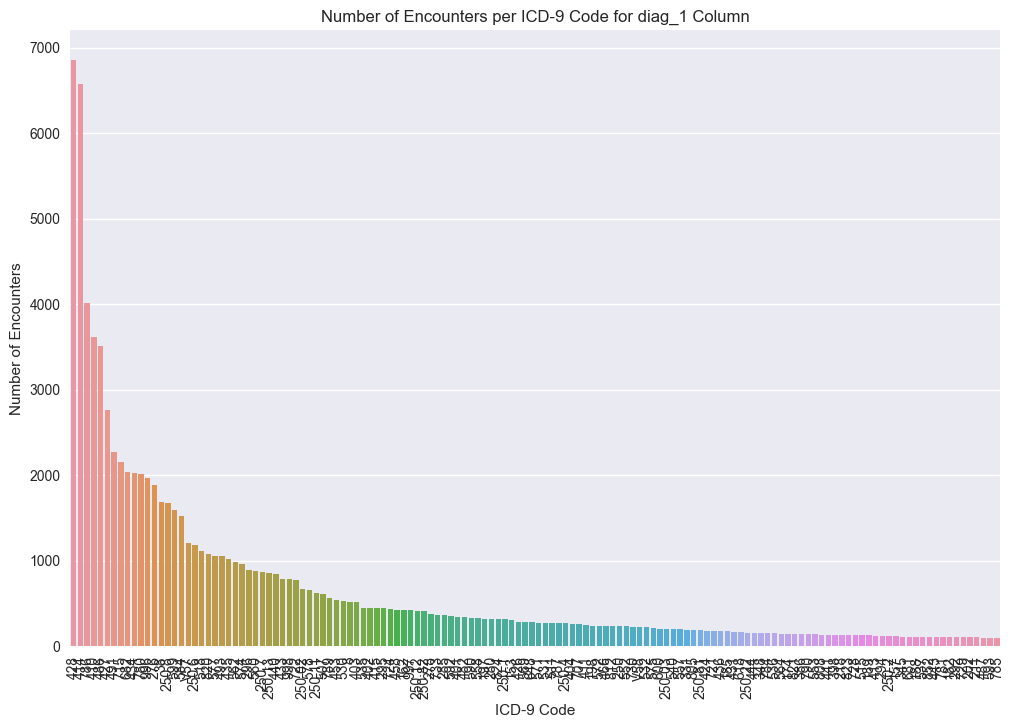

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_encounter_counts_diag1, x='ICD-9 Code', y='Number of Encounters')
plt.xticks(rotation=90)
plt.title('Number of Encounters per ICD-9 Code for diag_1 Column')
plt.show()


In [9]:
# Define the number of top ICD-9 codes you want to focus on
n = 20  # or any other desired number

# Obtain top n ICD-9 codes by number of encounters
top_n_codes1 = encounter_counts_diag1.head(n)['ICD-9 Code'].tolist()

# Filter dataframe to only include top n ICD-9 codes
top_n_df = df[df['diag_1'].isin(top_n_codes1)]

# Group by ICD-9 codes and calculate re-admission rates
# Assuming 'readmitted' column has values 'YES' for readmitted and 'NO' for not-readmitted
readmission_rates = top_n_df.groupby('diag_1').apply(lambda x: sum(x['readmitted'] == '>30') / len(x)).reset_index()
readmission_rates.columns = ['ICD-9 Code', 'Re-admission Rate']



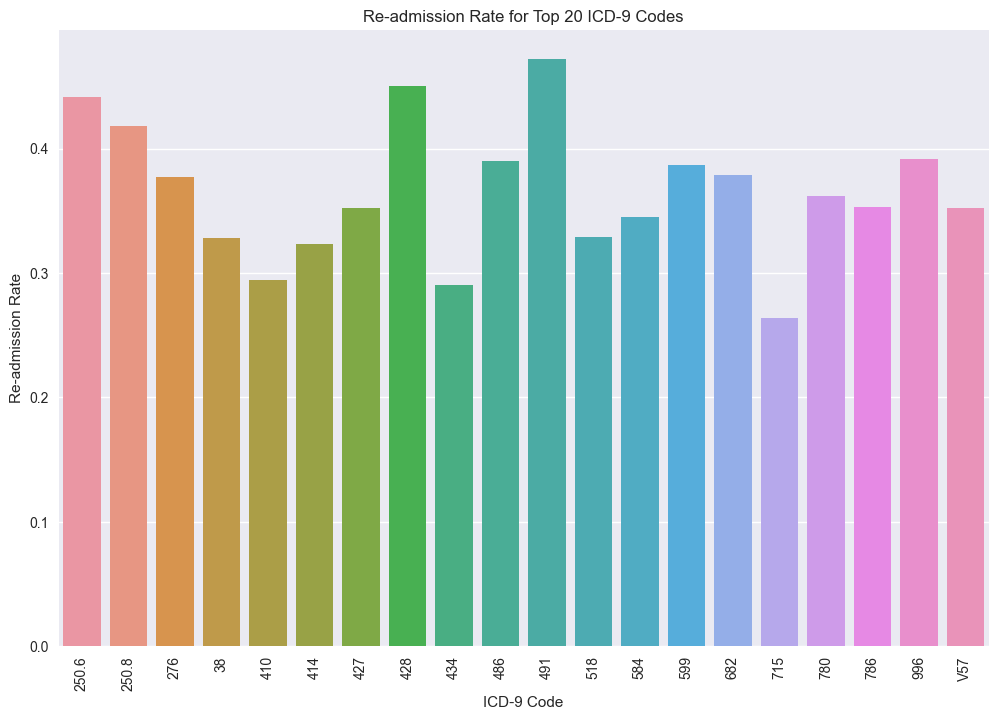

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=readmission_rates, x='ICD-9 Code', y=readmission_rates.columns[1])
plt.xticks(rotation=90)
plt.title(f'Re-admission Rate for Top {n} ICD-9 Codes')
plt.show()



In [11]:
encounter_counts_diag2 = df['diag_2'].value_counts().reset_index()
encounter_counts_diag2.columns = ['ICD-9 Code', 'Number of Encounters']

In [12]:
threshold = 100  # Adjust as needed
filtered_encounter_counts_diag2 = encounter_counts_diag2[encounter_counts_diag2['Number of Encounters'] > threshold]

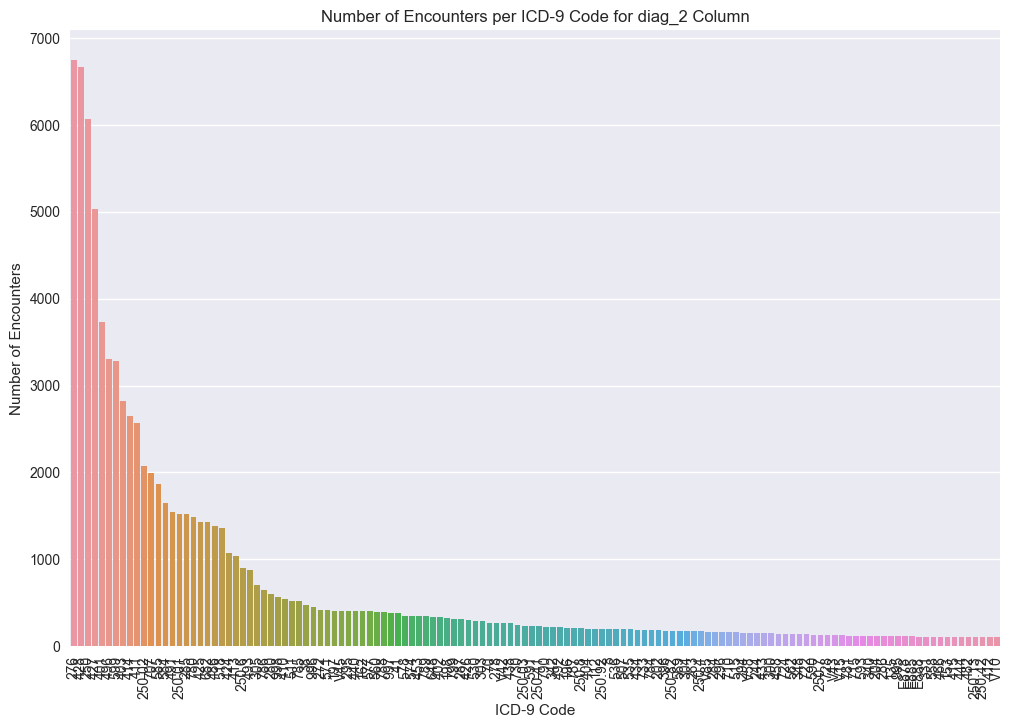

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_encounter_counts_diag2, x='ICD-9 Code', y='Number of Encounters')
plt.xticks(rotation=90)
plt.title('Number of Encounters per ICD-9 Code for diag_2 Column')
plt.show()


In [14]:
# Define the number of top ICD-9 codes you want to focus on
n = 20  # or any other desired number

# Obtain top n ICD-9 codes by number of encounters
top_n_codes2 = encounter_counts_diag2.head(n)['ICD-9 Code'].tolist()

# Filter dataframe to only include top n ICD-9 codes
top_n_df = df[df['diag_2'].isin(top_n_codes2)]

# Group by ICD-9 codes and calculate re-admission rates
# Assuming 'readmitted' column has values '>30' for readmitted and 'NO' for not-readmitted
readmission_rates = top_n_df.groupby('diag_2').apply(lambda x: sum(x['readmitted'] == '>30') / len(x)).reset_index()
readmission_rates.columns = ['ICD-9 Code', 'Re-admission Rate']


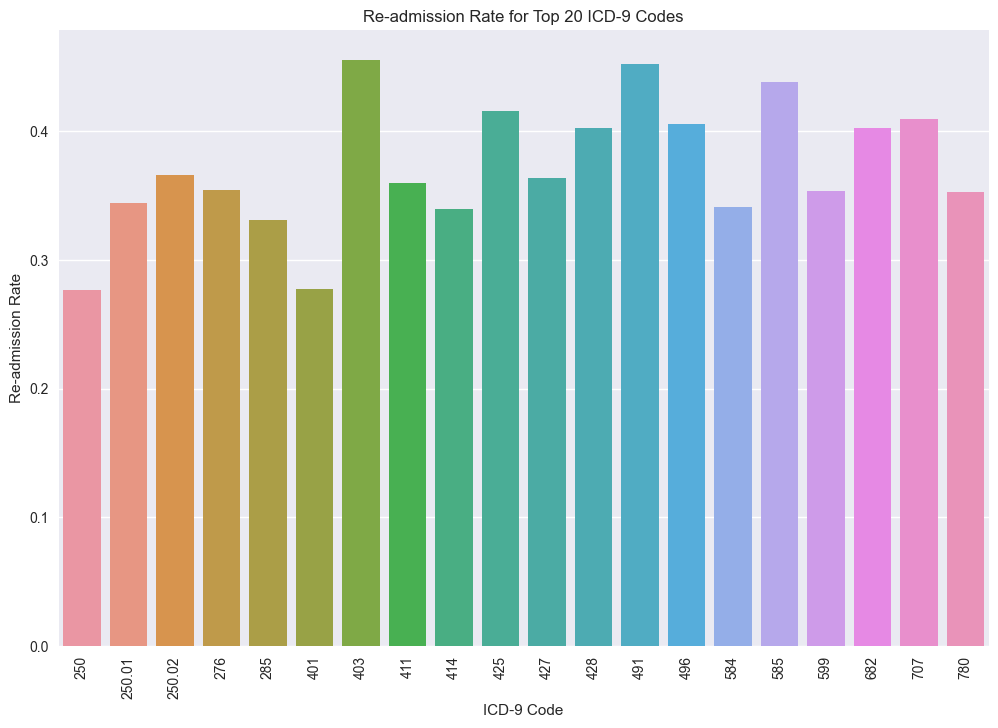

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=readmission_rates, x='ICD-9 Code', y=readmission_rates.columns[1])
plt.xticks(rotation=90)
plt.title(f'Re-admission Rate for Top {n} ICD-9 Codes')
plt.show()

In [16]:
encounter_counts_diag3 = df['diag_3'].value_counts().reset_index()
encounter_counts_diag3.columns = ['ICD-9 Code', 'Number of Encounters']

In [17]:
threshold = 100  # Adjust as needed
filtered_encounter_counts_diag3 = encounter_counts_diag3[encounter_counts_diag3['Number of Encounters'] > threshold]

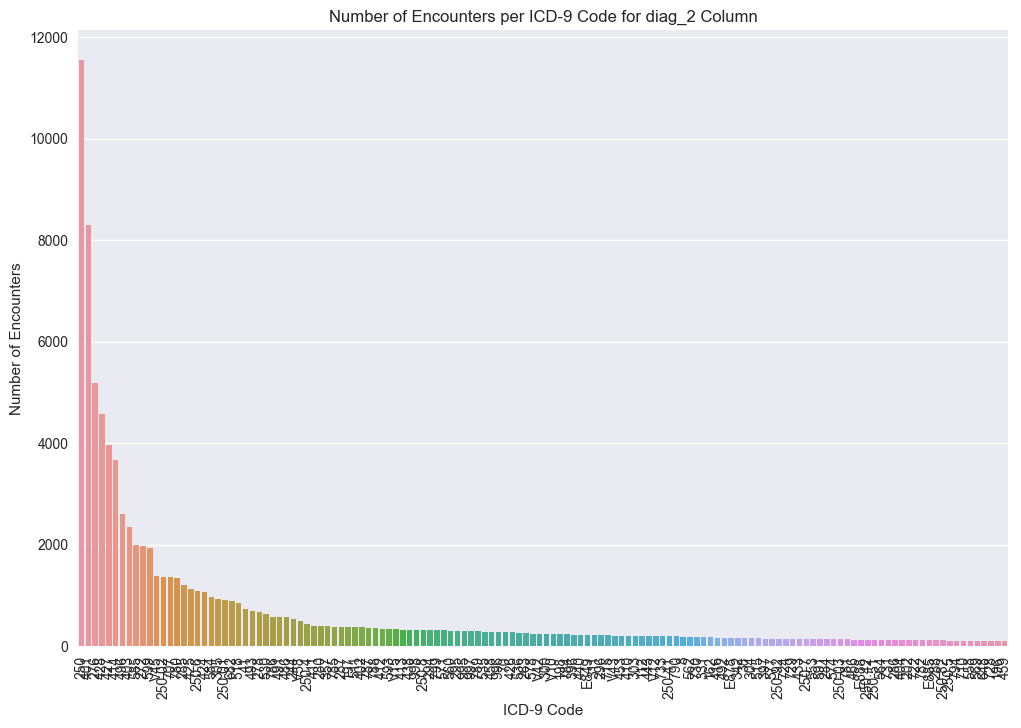

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_encounter_counts_diag3, x='ICD-9 Code', y='Number of Encounters')
plt.xticks(rotation=90)
plt.title('Number of Encounters per ICD-9 Code for diag_2 Column')
plt.show()


In [19]:
# Define the number of top ICD-9 codes you want to focus on
n = 20  # or any other desired number

# Obtain top n ICD-9 codes by number of encounters
top_n_codes3 = encounter_counts_diag3.head(n)['ICD-9 Code'].tolist()

# Filter dataframe to only include top n ICD-9 codes
top_n_df = df[df['diag_3'].isin(top_n_codes3)]

# Group by ICD-9 codes and calculate re-admission rates
# Assuming 'readmitted' column has values '>30' for readmitted and 'NO' for not-readmitted
readmission_rates = top_n_df.groupby('diag_3').apply(lambda x: sum(x['readmitted'] == '>30') / len(x)).reset_index()
readmission_rates.columns = ['ICD-9 Code', 'Re-admission Rate']


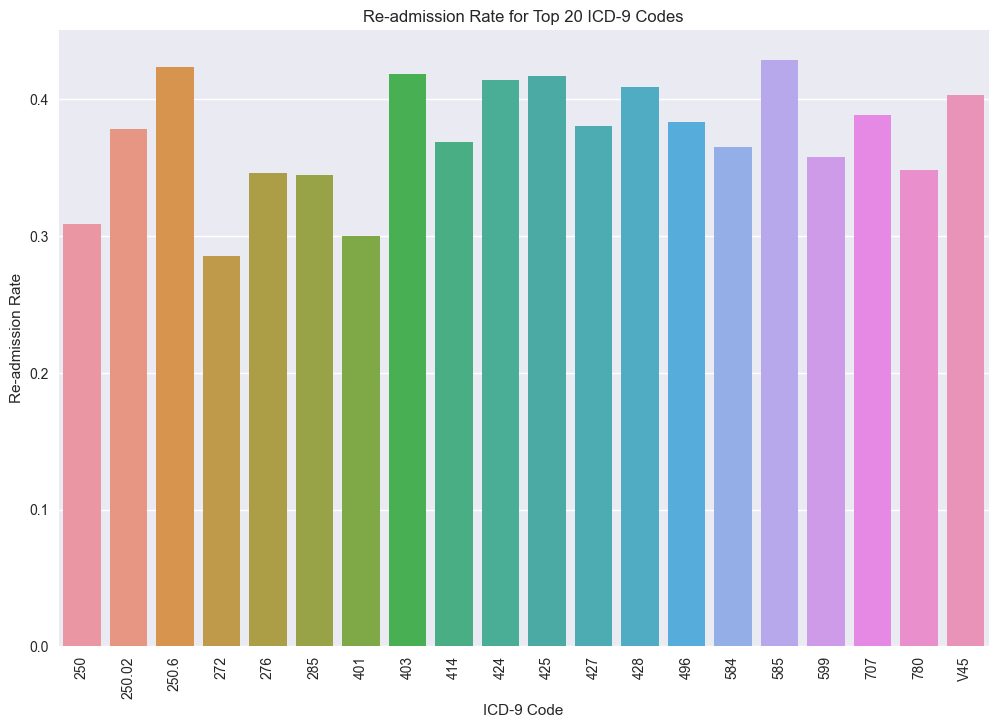

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=readmission_rates, x='ICD-9 Code', y=readmission_rates.columns[1])
plt.xticks(rotation=90)
plt.title(f'Re-admission Rate for Top {n} ICD-9 Codes')
plt.show()

In [21]:
# Calculate total number of encounters
total_encounters = encounter_counts_diag1['Number of Encounters'].sum()

# Calculate total unique ICD-9 codes
total_unique_icd9 = encounter_counts_diag1['ICD-9 Code'].nunique()

# Calculate the average number of encounters per ICD-9 code
average_encounters_per_icd9 = total_encounters / total_unique_icd9
print(f"Average number of encounters per ICD-9 code: {average_encounters_per_icd9}")


Average number of encounters per ICD-9 code: 142.10195530726256


In [22]:
# Calculate total number of encounters
total_encounters = encounter_counts_diag2['Number of Encounters'].sum()

# Calculate total unique ICD-9 codes
total_unique_icd9 = encounter_counts_diag2['ICD-9 Code'].nunique()

# Calculate the average number of encounters per ICD-9 code
average_encounters_per_icd9 = total_encounters / total_unique_icd9
print(f"Average number of encounters per ICD-9 code: {average_encounters_per_icd9}")


Average number of encounters per ICD-9 code: 135.57219251336898


In [23]:
# Calculate total number of encounters
total_encounters = encounter_counts_diag3['Number of Encounters'].sum()

# Calculate total unique ICD-9 codes
total_unique_icd9 = encounter_counts_diag3['ICD-9 Code'].nunique()

# Calculate the average number of encounters per ICD-9 code
average_encounters_per_icd9 = total_encounters / total_unique_icd9
print(f"Average number of encounters per ICD-9 code: {average_encounters_per_icd9}")


Average number of encounters per ICD-9 code: 127.17743979721166


In [24]:
# Combine all the codes into a single list
all_codes = top_n_codes1 + top_n_codes2 + top_n_codes3

# Convert the combined list into a set to get the unique codes
important_codes = list(set(all_codes))

# Print the unique important codes and their count
print(important_codes)
print("Total unique codes:", len(important_codes))


['411', '403', '428', '996', '584', '250.01', '780', '250.8', '410', '427', '715', '272', '250', '585', '425', '250.02', '486', '414', '496', '401', 'V45', '518', '786', '276', '424', '285', '707', '491', '38', '250.6', '682', 'V57', '434', '599']
Total unique codes: 34


In [25]:
# Ensure all diagnosis columns contain only the important codes
filtered_df = df[
    df['diag_1'].isin(important_codes) & 
    df['diag_2'].isin(important_codes) & 
    df['diag_3'].isin(important_codes)
]

In [26]:
filtered_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
5,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),NaN,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
13,42570,77586282,Caucasian,Male,[80-90),NaN,1,6,7,10,...,No,Steady,No,No,No,No,No,No,Yes,NO
16,77076,92519352,AfricanAmerican,Male,[50-60),NaN,1,1,7,4,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
20,150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,...,No,Down,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101743,443793668,47293812,Caucasian,Male,[80-90),NaN,1,13,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101744,443793992,43686936,Caucasian,Female,[80-90),NaN,1,1,7,1,...,No,No,No,No,No,No,No,No,No,NO
101746,443797298,89955270,Caucasian,Male,[70-80),NaN,1,1,7,4,...,No,No,No,No,No,No,No,No,Yes,<30
101749,443816024,106392411,Caucasian,Female,[70-80),NaN,3,6,1,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [27]:
# Extract unique codes from each diagnosis column
unique_diag1 = filtered_df['diag_1'].unique().tolist()
unique_diag2 = filtered_df['diag_2'].unique().tolist()
unique_diag3 = filtered_df['diag_3'].unique().tolist()

# Combine the unique codes from the three columns
all_unique_codes_in_filtered_df = set(unique_diag1 + unique_diag2 + unique_diag3)

# Check if each code in the combined unique codes list is in the important_codes list
if all(code in important_codes for code in all_unique_codes_in_filtered_df):
    print("All codes in the filtered_df are from the important_codes list.")
else:
    unexpected_codes = [code for code in all_unique_codes_in_filtered_df if code not in important_codes]
    print("The following unexpected codes were found in the filtered_df:", unexpected_codes)


All codes in the filtered_df are from the important_codes list.


In [28]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29089 entries, 5 to 101756
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              29089 non-null  int64 
 1   patient_nbr               29089 non-null  int64 
 2   race                      28447 non-null  object
 3   gender                    29089 non-null  object
 4   age                       29089 non-null  object
 5   weight                    763 non-null    object
 6   admission_type_id         29089 non-null  int64 
 7   discharge_disposition_id  29089 non-null  int64 
 8   admission_source_id       29089 non-null  int64 
 9   time_in_hospital          29089 non-null  int64 
 10  payer_code                17223 non-null  object
 11  medical_specialty         14510 non-null  object
 12  num_lab_procedures        29089 non-null  int64 
 13  num_procedures            29089 non-null  int64 
 14  num_medications      

In [29]:
# Get the unique unexpected codes as discussed before
unique_diag1 = filtered_df['diag_1'].unique().tolist()
unique_diag2 = filtered_df['diag_2'].unique().tolist()
unique_diag3 = filtered_df['diag_3'].unique().tolist()

all_unique_codes_in_filtered_df = set(unique_diag1 + unique_diag2 + unique_diag3)
unexpected_codes = [code for code in all_unique_codes_in_filtered_df if code not in important_codes]

# Print the unexpected codes
print("Unexpected codes:", unexpected_codes)

# Display a few rows that contain these unexpected codes
sample_rows = filtered_df[filtered_df['diag_1'].isin(unexpected_codes) | 
                          filtered_df['diag_2'].isin(unexpected_codes) | 
                          filtered_df['diag_3'].isin(unexpected_codes)].head()

print(sample_rows)


Unexpected codes: []
Empty DataFrame
Columns: [encounter_id, patient_nbr, race, gender, age, weight, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, payer_code, medical_specialty, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, diag_1, diag_2, diag_3, number_diagnoses, max_glu_serum, A1Cresult, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, change, diabetesMed, readmitted]
Index: []

[0 rows x 50 columns]


In [30]:
filtered_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,2.908900e+04,2.908900e+04,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000
mean,1.627433e+08,5.414796e+07,1.992884,3.776101,5.975386,4.172780,43.693080,1.497542,16.782254,0.387741,0.164117,0.638420,7.546151
std,1.011385e+08,3.852743e+07,1.465705,5.273308,4.012607,2.856075,19.483728,1.961049,8.552535,1.315758,0.649810,1.200976,1.821503
min,3.575400e+04,1.305000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,8.401738e+07,2.335349e+07,1.000000,1.000000,1.000000,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,1.510178e+08,4.494246e+07,1.000000,1.000000,7.000000,3.000000,45.000000,1.000000,15.000000,0.000000,0.000000,0.000000,9.000000
75%,2.246536e+08,8.735301e+07,3.000000,4.000000,7.000000,6.000000,57.000000,3.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438421e+08,1.893659e+08,8.000000,28.000000,22.000000,14.000000,129.000000,6.000000,81.000000,36.000000,22.000000,16.000000,16.000000


In [31]:
filtered_df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                          642
gender                          0
age                             0
weight                      28326
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  11866
medical_specialty           14579
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 


Frequency count for column: race
Caucasian          22467
AfricanAmerican     4908
Hispanic             491
Other                421
Asian                160
Name: race, dtype: int64


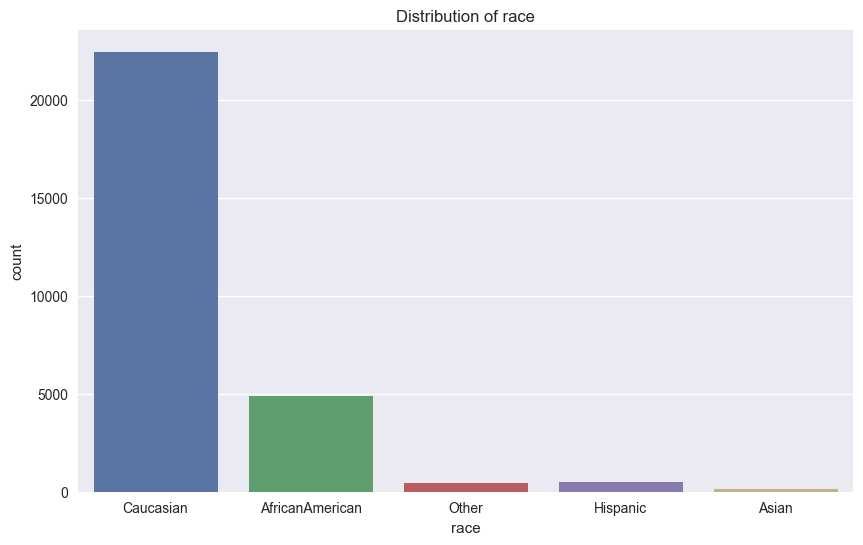


Frequency count for column: gender
Female             14891
Male               14197
Unknown/Invalid        1
Name: gender, dtype: int64


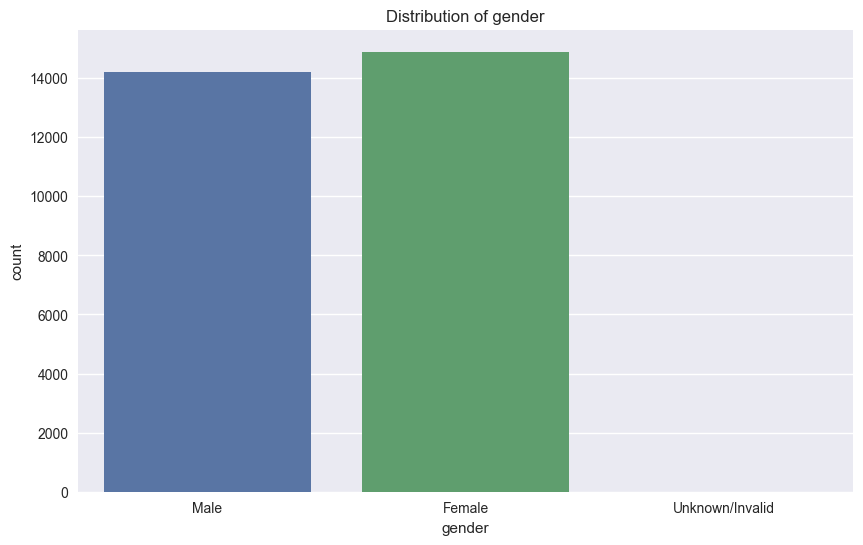


Frequency count for column: age
[70-80)     8578
[60-70)     7013
[80-90)     5532
[50-60)     4664
[40-50)     1859
[90-100)     937
[30-40)      428
[20-30)       71
[10-20)        7
Name: age, dtype: int64


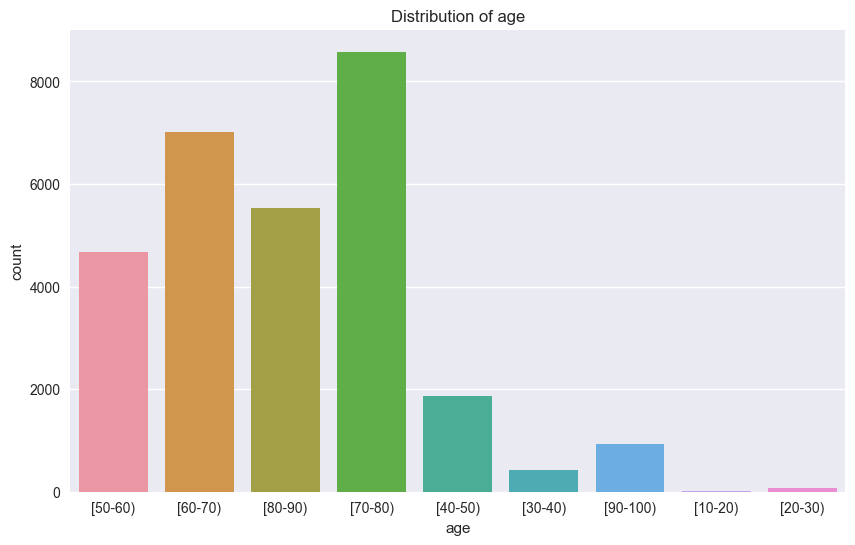


Frequency count for column: weight
[75-100)     329
[50-75)      181
[100-125)    176
[125-150)     29
[25-50)       22
[0-25)        13
[150-175)     11
[175-200)      2
Name: weight, dtype: int64


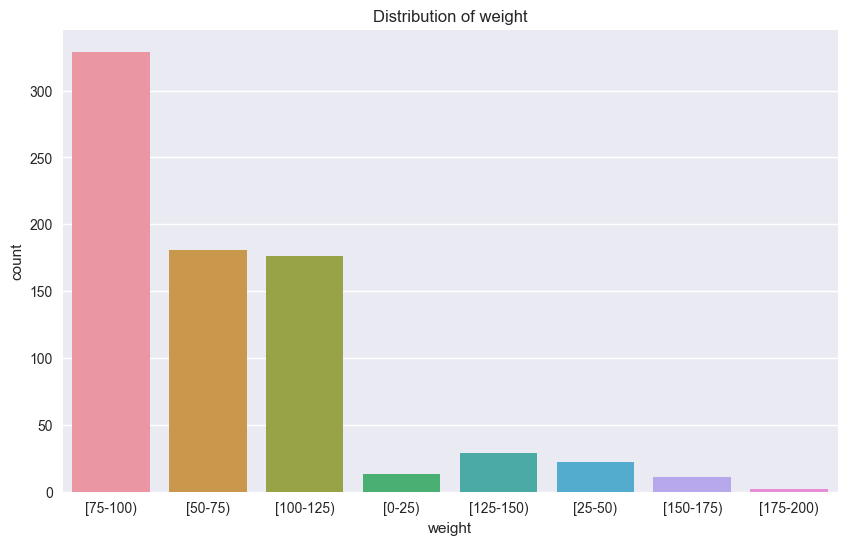


Frequency count for column: payer_code
MC    9912
HM    1740
SP    1308
BC    1131
MD     792
CP     639
UN     607
CM     591
OG     212
PO     118
DM      99
CH      37
OT      21
WC       6
MP       5
SI       4
FR       1
Name: payer_code, dtype: int64


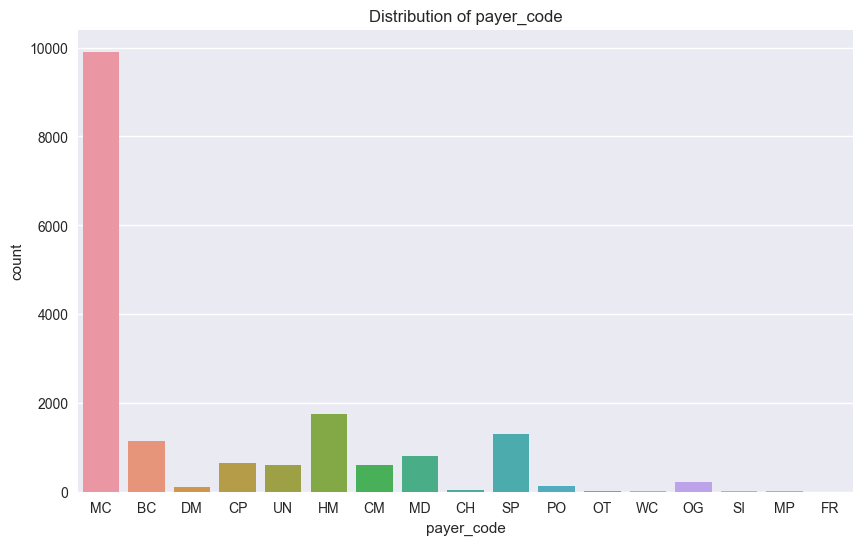


Frequency count for column: medical_specialty
InternalMedicine                     4184
Cardiology                           2853
Family/GeneralPractice               2109
Emergency/Trauma                     2080
Radiologist                           524
Nephrology                            514
Orthopedics                           427
Surgery-General                       409
Orthopedics-Reconstructive            331
Surgery-Cardiovascular/Thoracic       248
Pulmonology                           242
PhysicalMedicineandRehabilitation     105
Gastroenterology                       90
Surgery-Vascular                       75
Pediatrics                             47
Urology                                32
Surgery-Thoracic                       28
Endocrinology                          23
Podiatry                               21
Surgery-Cardiovascular                 20
Neurology                              18
Oncology                               14
Radiology                    

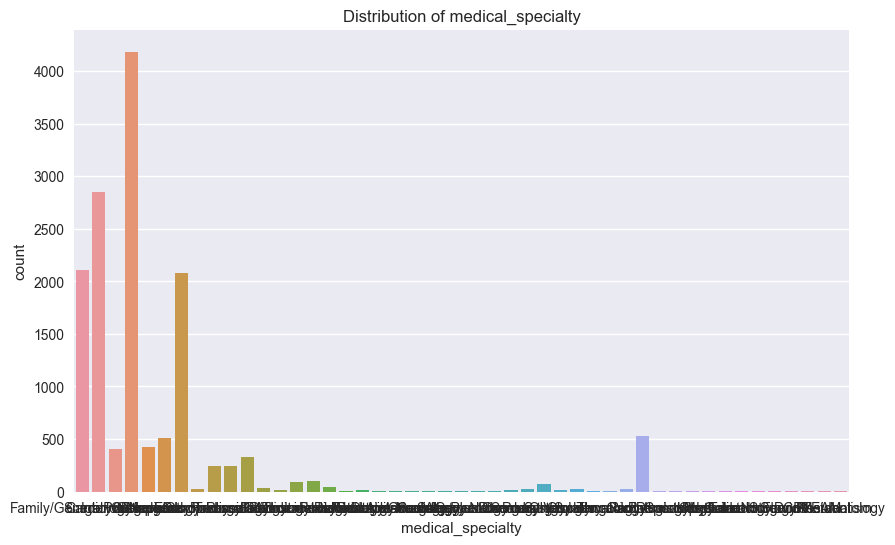


Frequency count for column: diag_1
428       4434
414       4067
410       2474
786       2236
486       1951
427       1666
715       1237
491       1202
780        903
434        888
584        878
996        827
682        789
38         740
250.8      739
276        707
599        671
518        635
250.6      387
403        297
V57        287
250.02     223
411        150
285        135
401        134
707        109
424        108
250         80
425         57
496         39
585         31
250.01       6
V45          2
Name: diag_1, dtype: int64


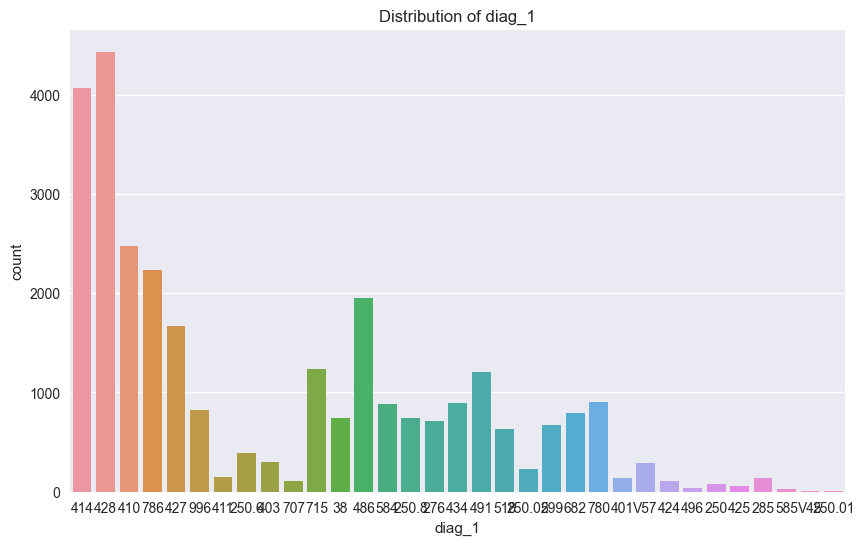


Frequency count for column: diag_2
428       3506
427       2588
276       2052
411       1971
250       1885
414       1747
401       1699
496       1377
403       1262
599       1142
491        901
425        860
585        857
250.02     753
707        720
486        697
584        638
424        556
518        523
682        468
780        432
250.01     426
285        394
410        316
786        268
V45        228
272        194
996        170
38         162
250.6      108
434         77
250.8       67
715         41
V57          4
Name: diag_2, dtype: int64


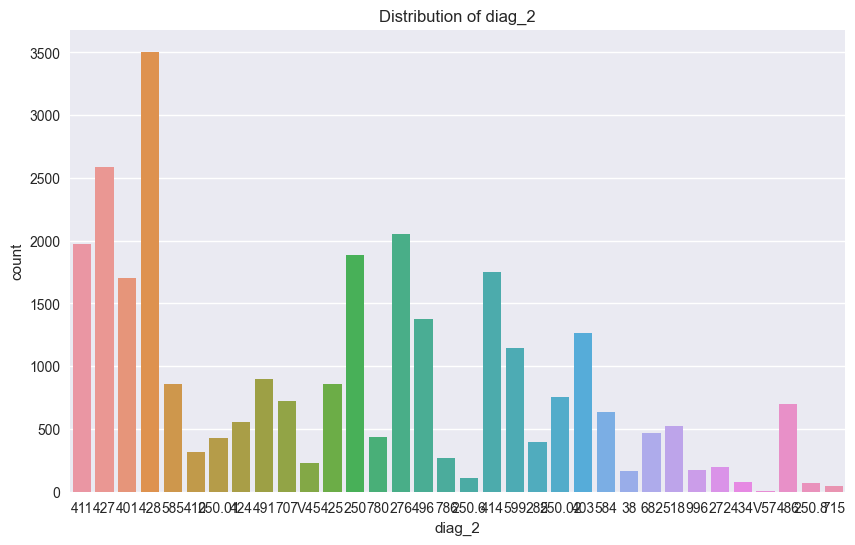


Frequency count for column: diag_3
250       4283
401       3530
428       2201
427       2102
414       2062
276       1975
496       1202
403       1149
272       1081
585        999
599        800
V45        787
424        651
425        651
250.02     633
707        530
780        483
584        468
682        385
250.01     385
491        358
518        346
250.6      338
285        338
411        299
486        291
786        246
996        135
250.8      126
410        108
715         61
38          60
434         22
V57          4
Name: diag_3, dtype: int64


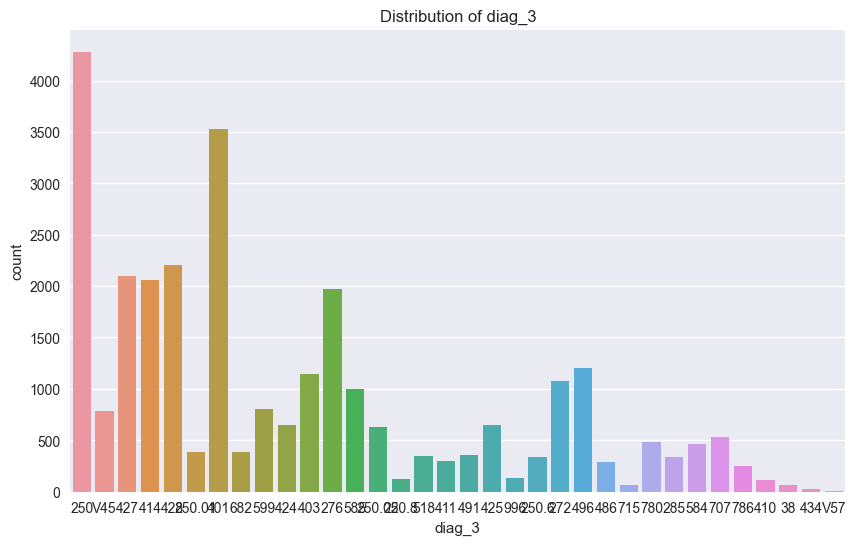


Frequency count for column: max_glu_serum
None    27528
Norm      734
>200      479
>300      348
Name: max_glu_serum, dtype: int64


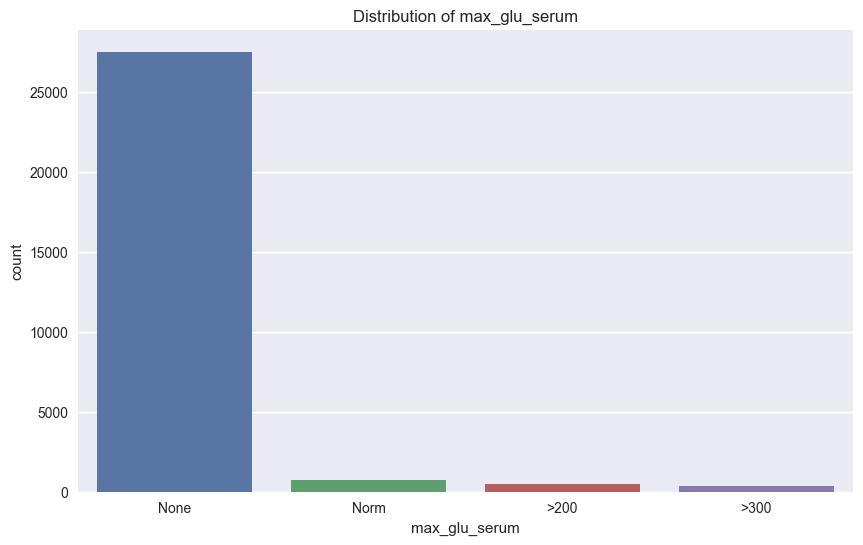


Frequency count for column: A1Cresult
None    24082
>8       2322
Norm     1452
>7       1233
Name: A1Cresult, dtype: int64


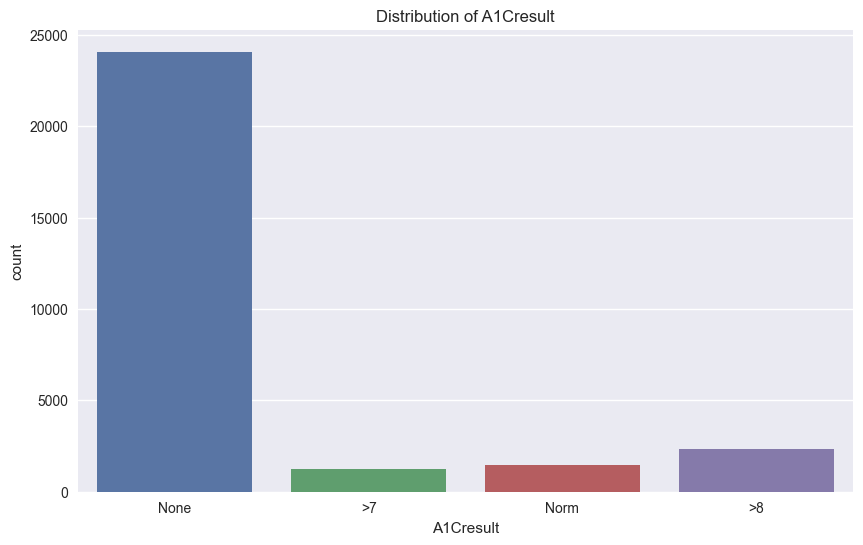


Frequency count for column: metformin
No        23795
Steady     4875
Up          266
Down        153
Name: metformin, dtype: int64


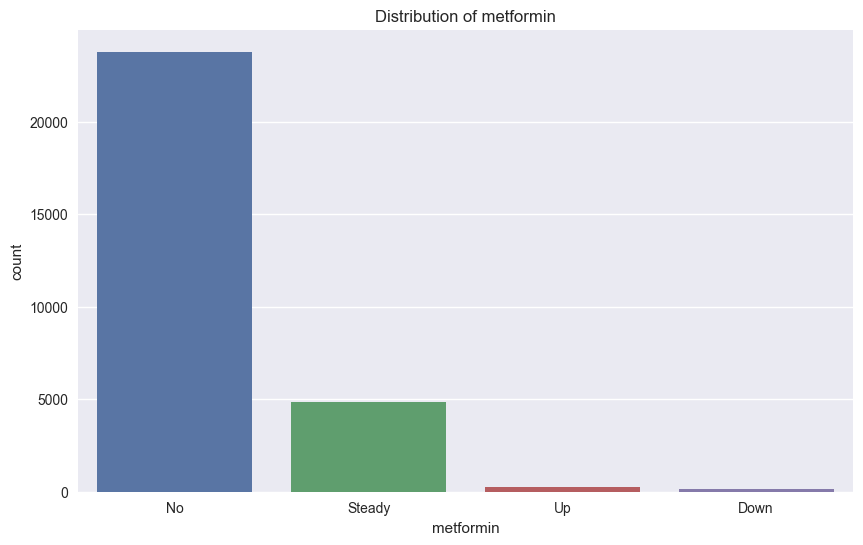


Frequency count for column: repaglinide
No        28534
Steady      488
Up           43
Down         24
Name: repaglinide, dtype: int64


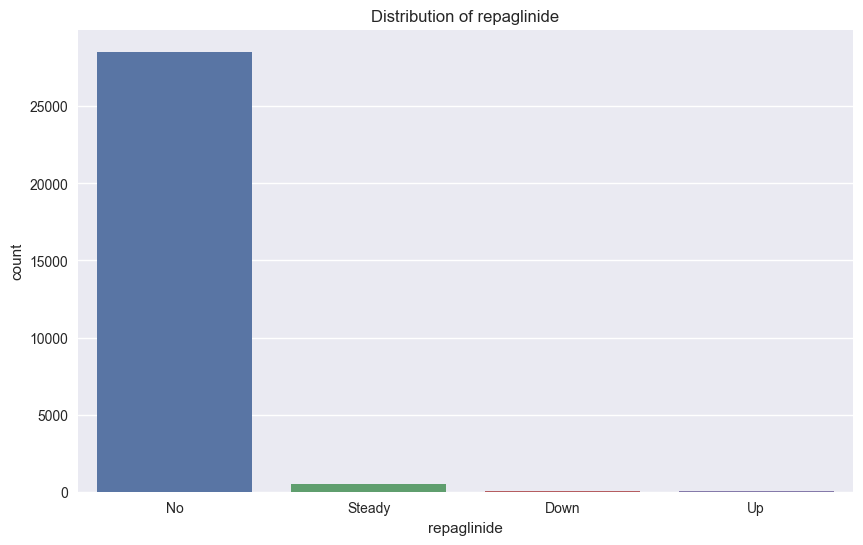


Frequency count for column: nateglinide
No        28877
Steady      199
Up           10
Down          3
Name: nateglinide, dtype: int64


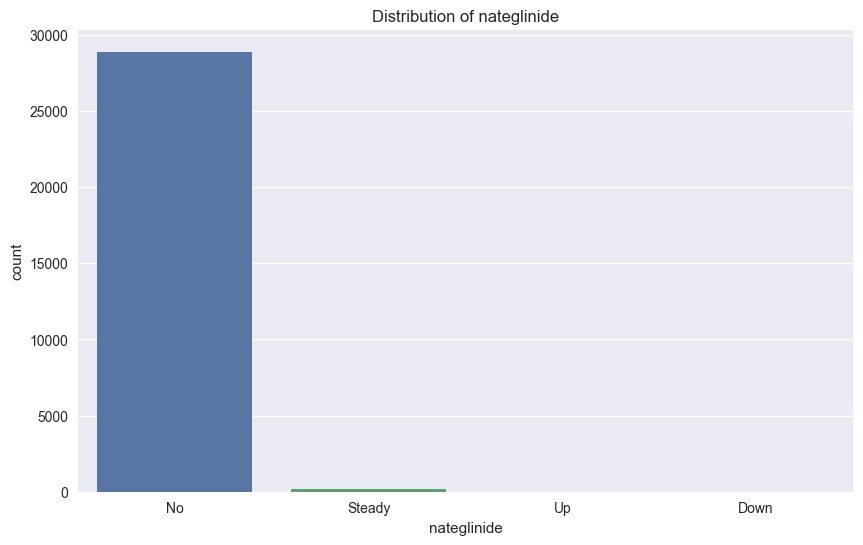


Frequency count for column: chlorpropamide
No        29049
Steady       37
Up            3
Name: chlorpropamide, dtype: int64


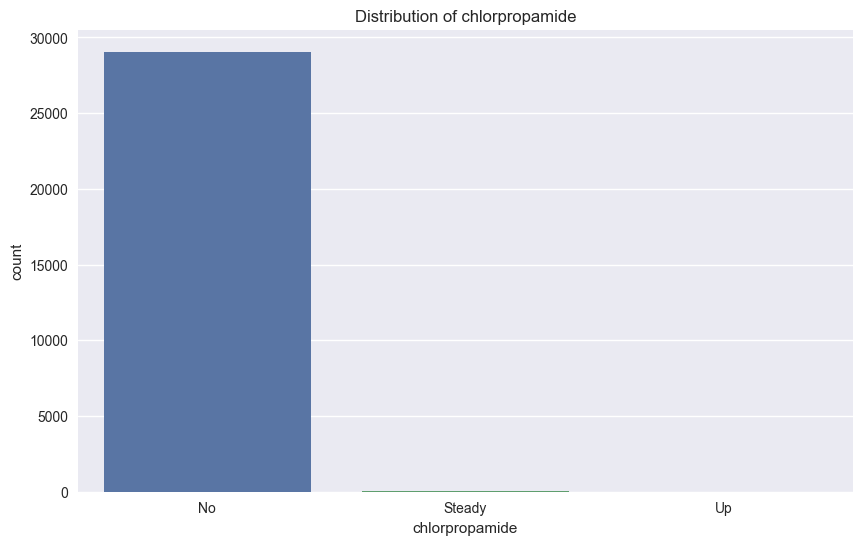


Frequency count for column: glimepiride
No        27439
Steady     1494
Up          105
Down         51
Name: glimepiride, dtype: int64


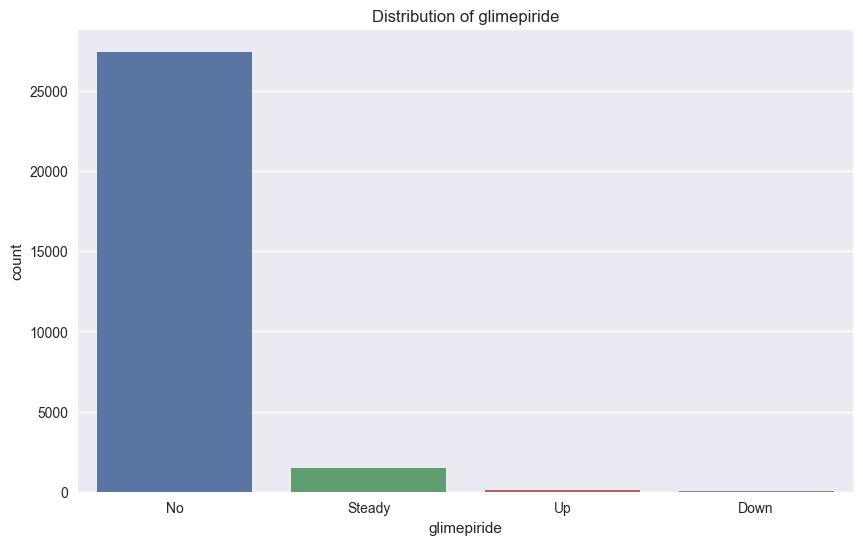


Frequency count for column: acetohexamide
No        29088
Steady        1
Name: acetohexamide, dtype: int64


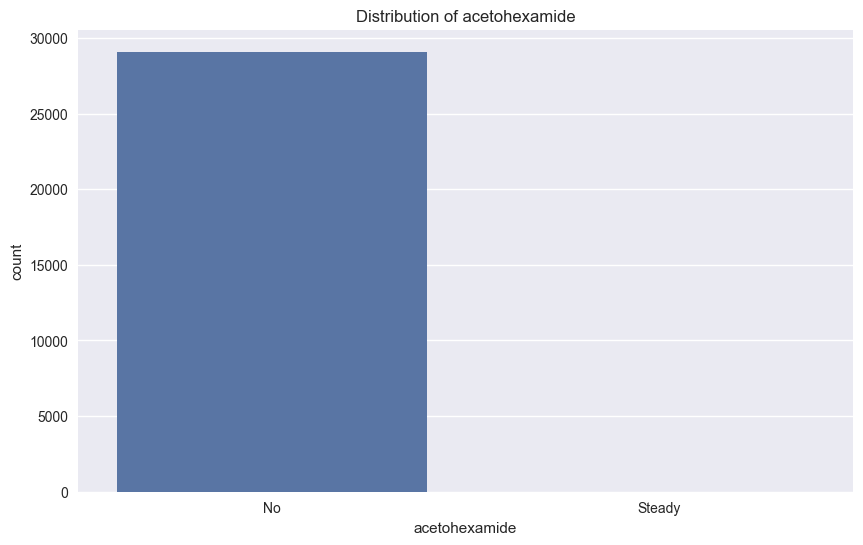


Frequency count for column: glipizide
No        24942
Steady     3714
Up          251
Down        182
Name: glipizide, dtype: int64


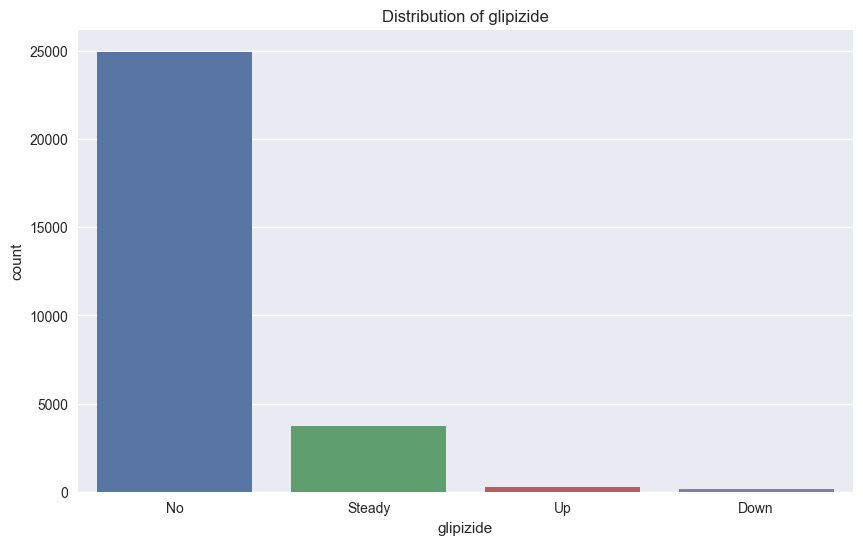


Frequency count for column: glyburide
No        25582
Steady     3088
Up          235
Down        184
Name: glyburide, dtype: int64


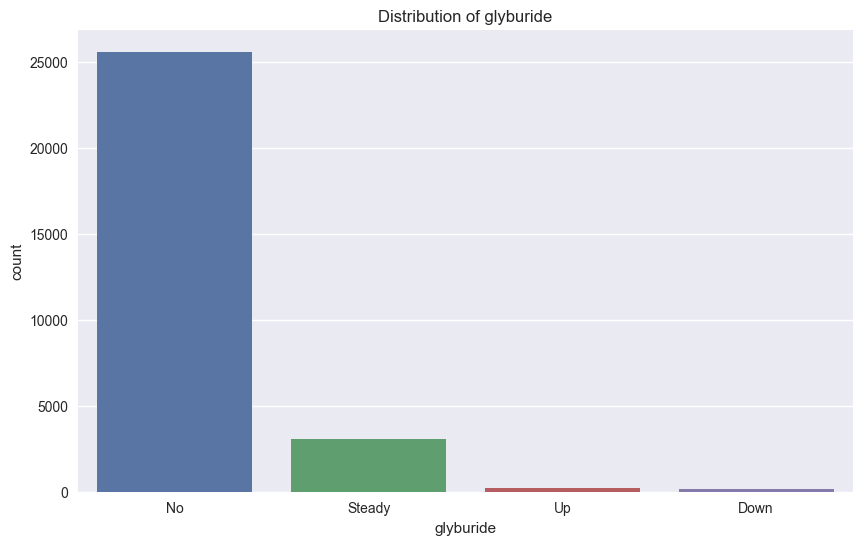


Frequency count for column: tolbutamide
No        29084
Steady        5
Name: tolbutamide, dtype: int64


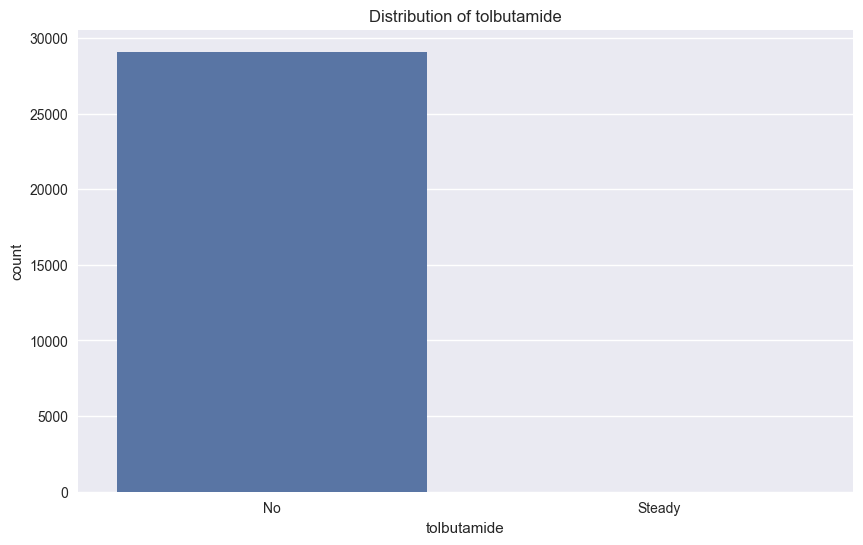


Frequency count for column: pioglitazone
No        26785
Steady     2202
Up           66
Down         36
Name: pioglitazone, dtype: int64


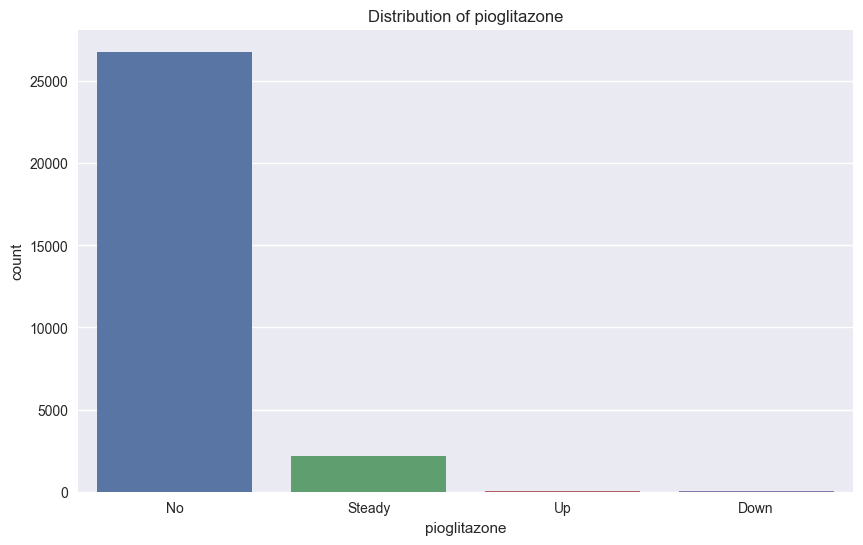


Frequency count for column: rosiglitazone
No        27167
Steady     1849
Up           48
Down         25
Name: rosiglitazone, dtype: int64


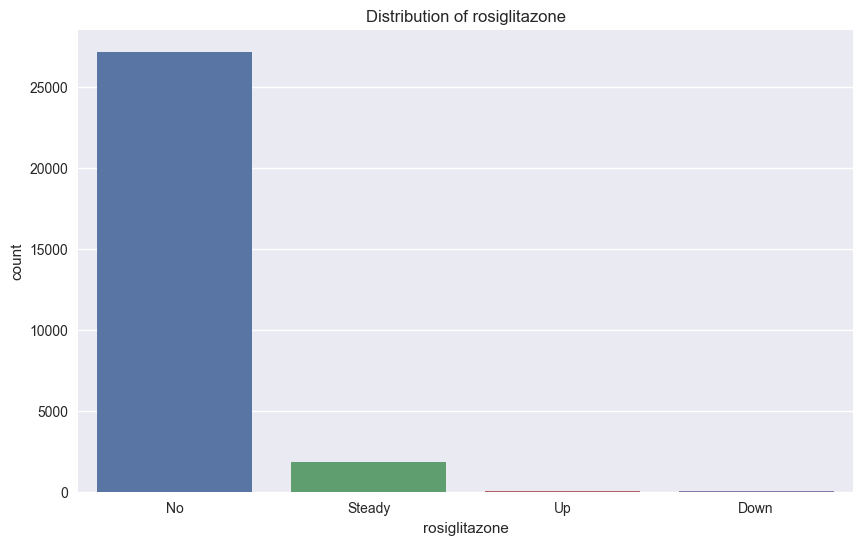


Frequency count for column: acarbose
No        28979
Steady      105
Up            5
Name: acarbose, dtype: int64


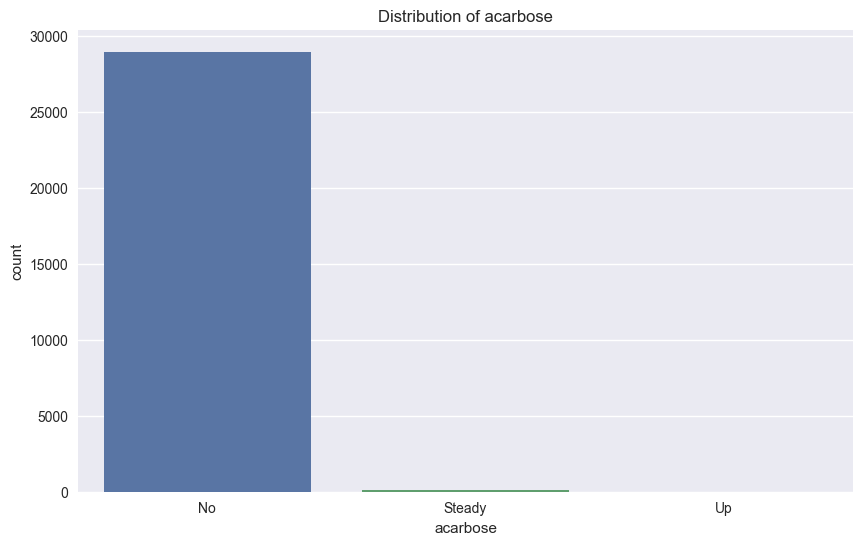


Frequency count for column: miglitol
No        29081
Steady        7
Up            1
Name: miglitol, dtype: int64


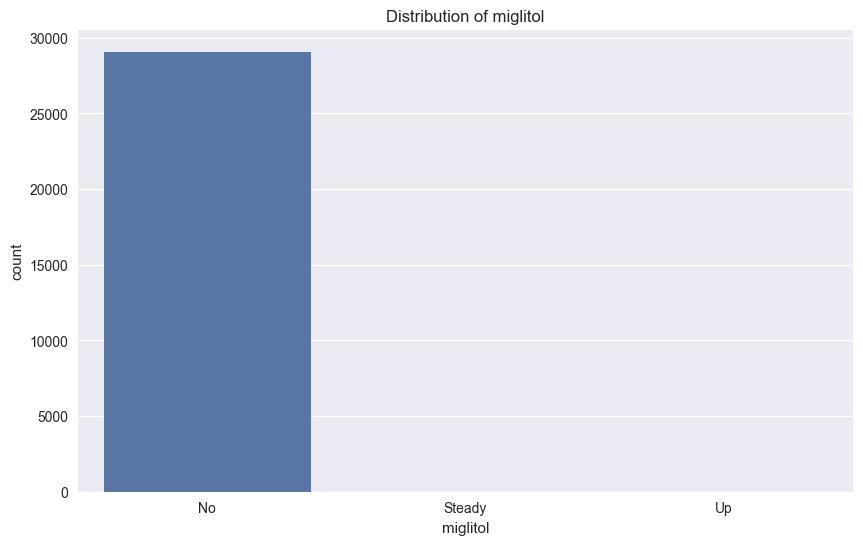


Frequency count for column: troglitazone
No        29088
Steady        1
Name: troglitazone, dtype: int64


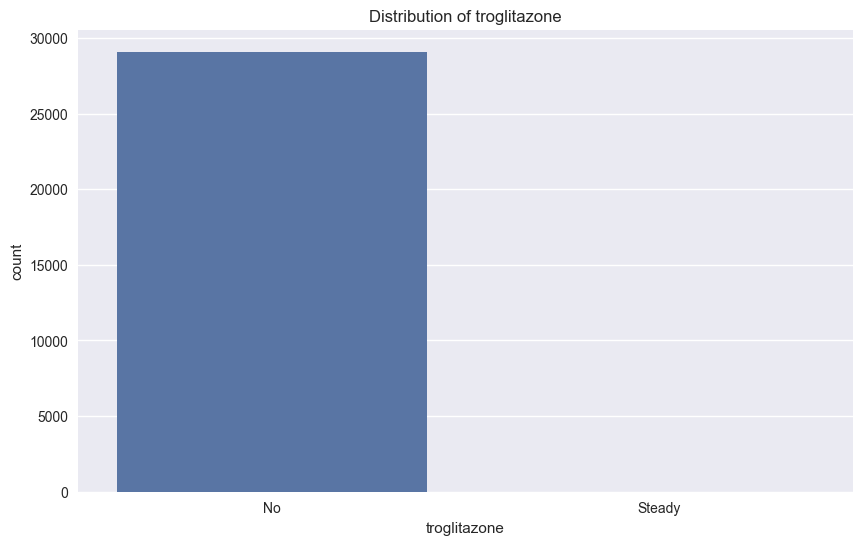


Frequency count for column: tolazamide
No        29074
Steady       15
Name: tolazamide, dtype: int64


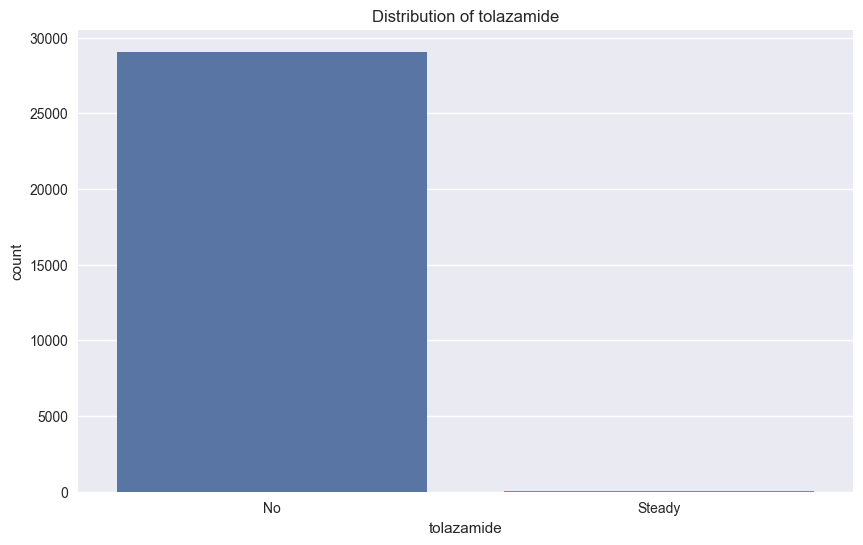


Frequency count for column: examide
No    29089
Name: examide, dtype: int64


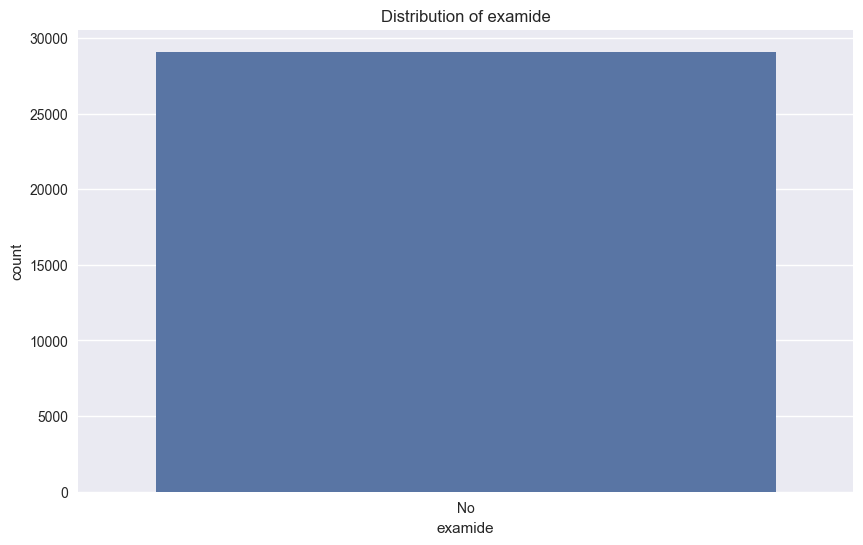


Frequency count for column: citoglipton
No    29089
Name: citoglipton, dtype: int64


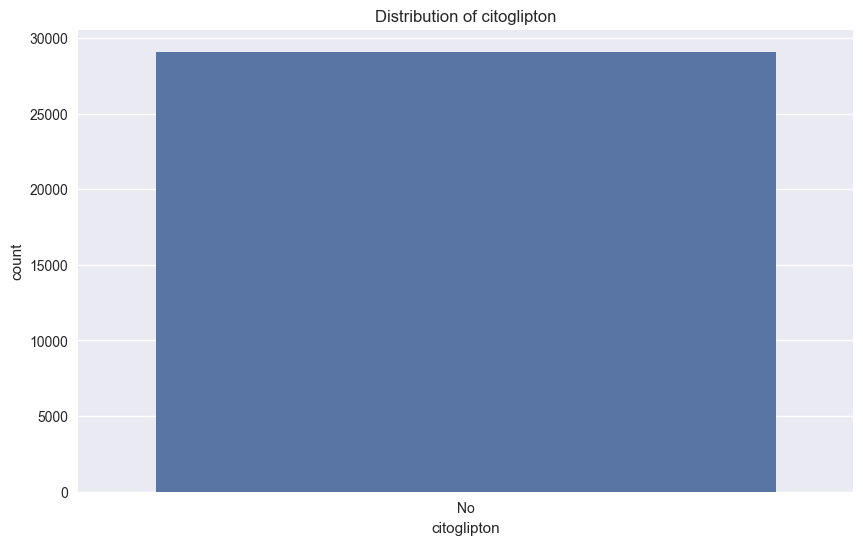


Frequency count for column: insulin
No        13728
Steady     8717
Down       3481
Up         3163
Name: insulin, dtype: int64


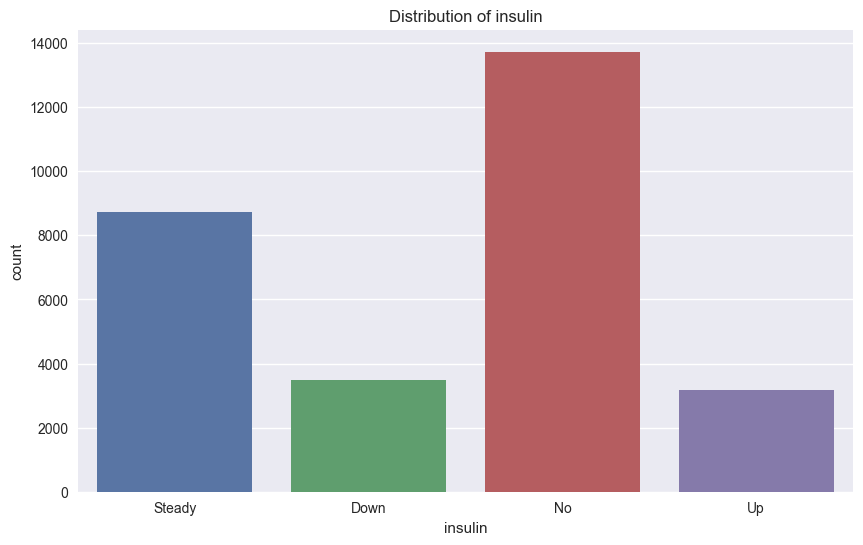


Frequency count for column: glyburide-metformin
No        28916
Steady      169
Up            4
Name: glyburide-metformin, dtype: int64


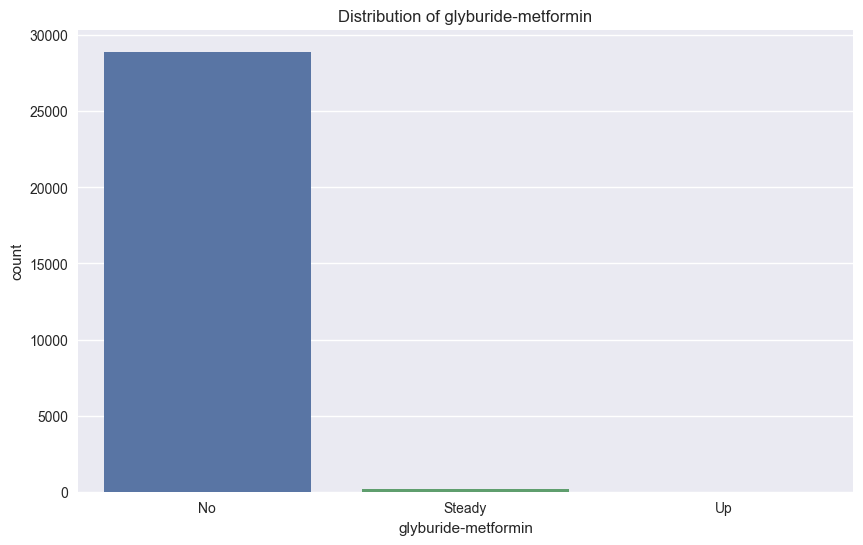


Frequency count for column: glipizide-metformin
No        29085
Steady        4
Name: glipizide-metformin, dtype: int64


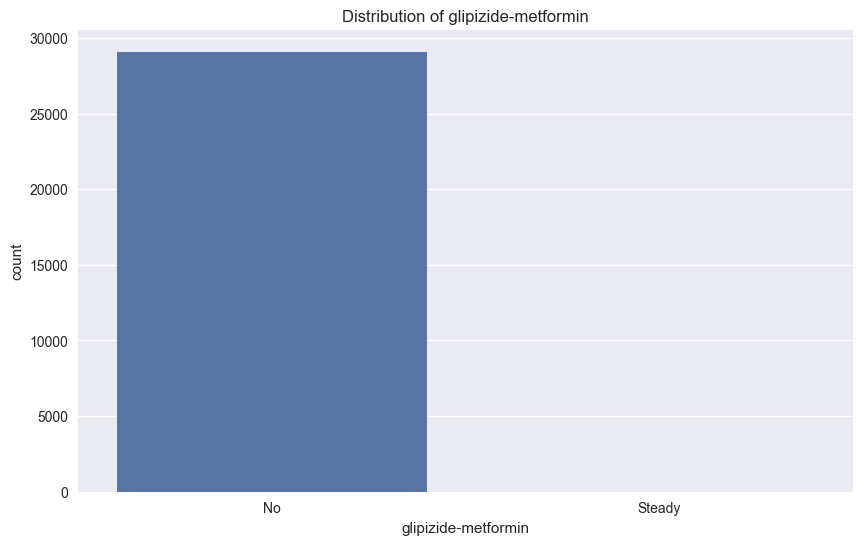


Frequency count for column: glimepiride-pioglitazone
No    29089
Name: glimepiride-pioglitazone, dtype: int64


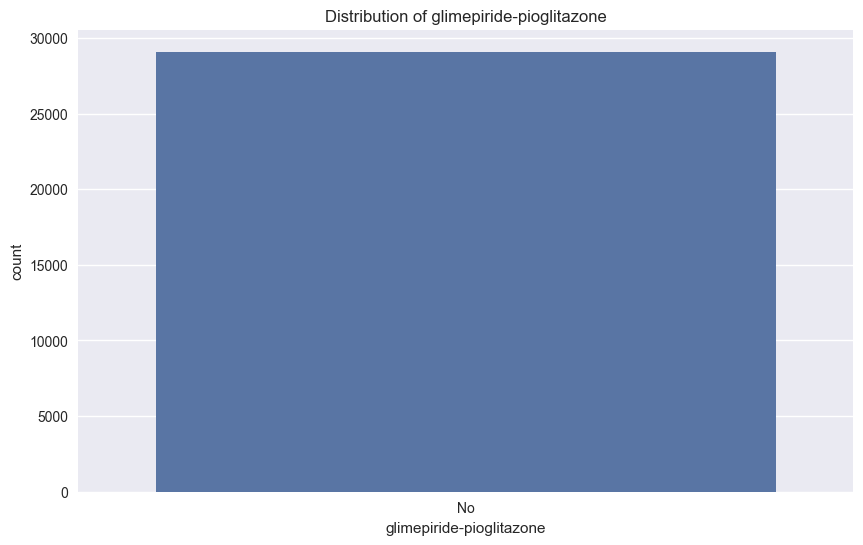


Frequency count for column: metformin-rosiglitazone
No    29089
Name: metformin-rosiglitazone, dtype: int64


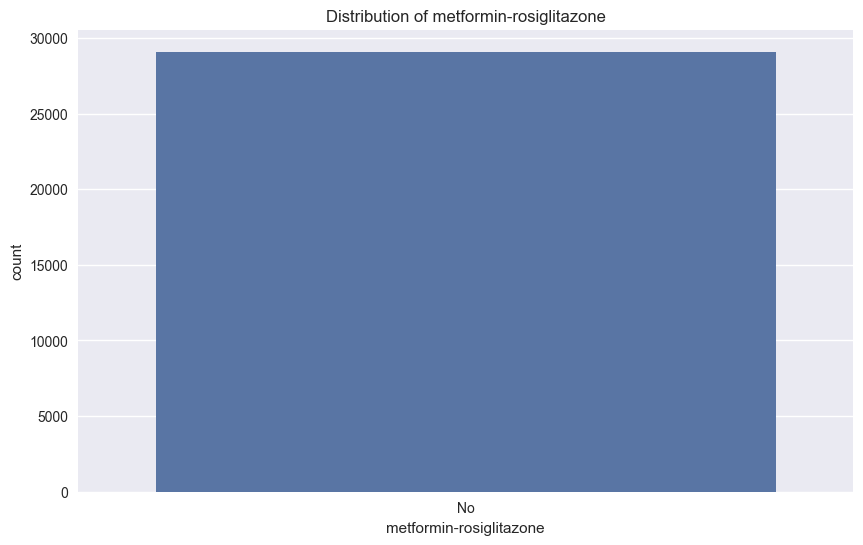


Frequency count for column: metformin-pioglitazone
No        29088
Steady        1
Name: metformin-pioglitazone, dtype: int64


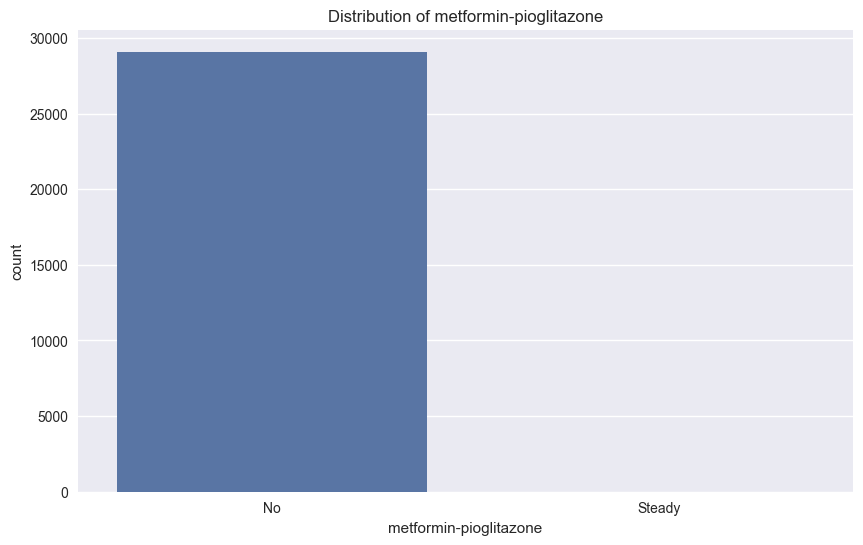


Frequency count for column: change
No    15367
Ch    13722
Name: change, dtype: int64


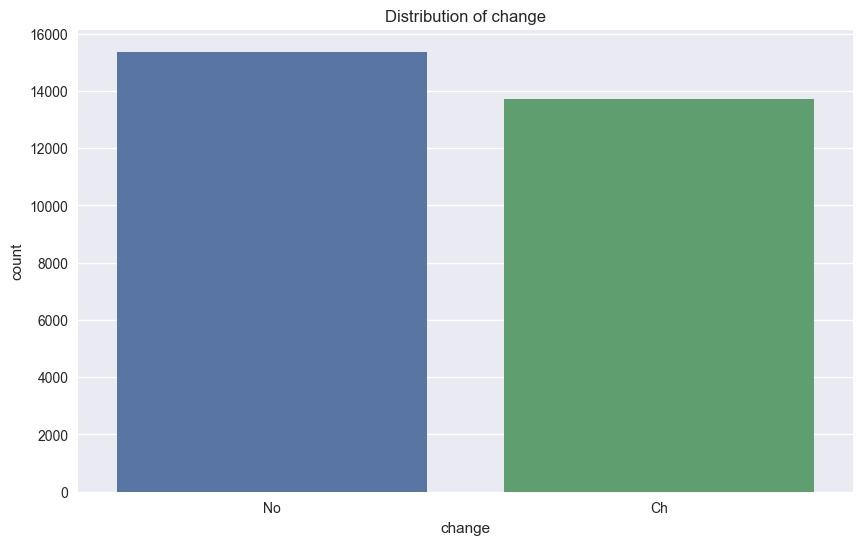


Frequency count for column: diabetesMed
Yes    22890
No      6199
Name: diabetesMed, dtype: int64


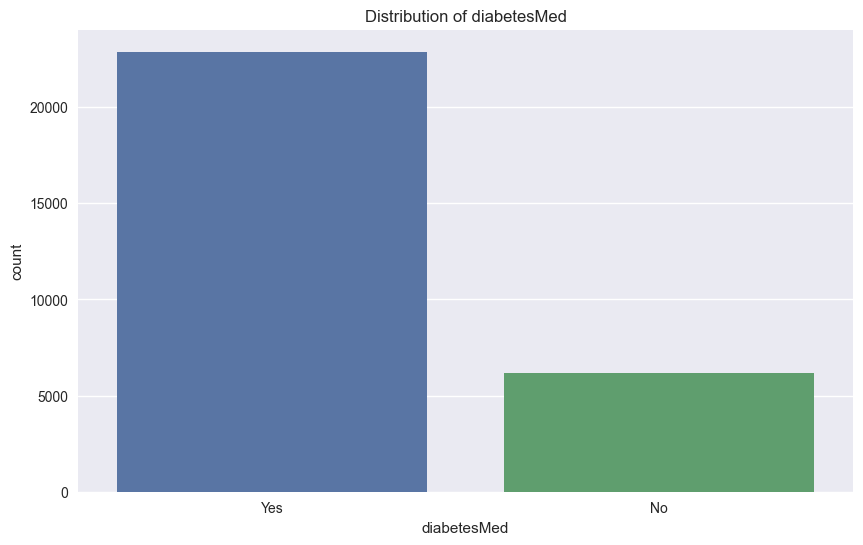


Frequency count for column: readmitted
NO     14923
>30    10992
<30     3174
Name: readmitted, dtype: int64


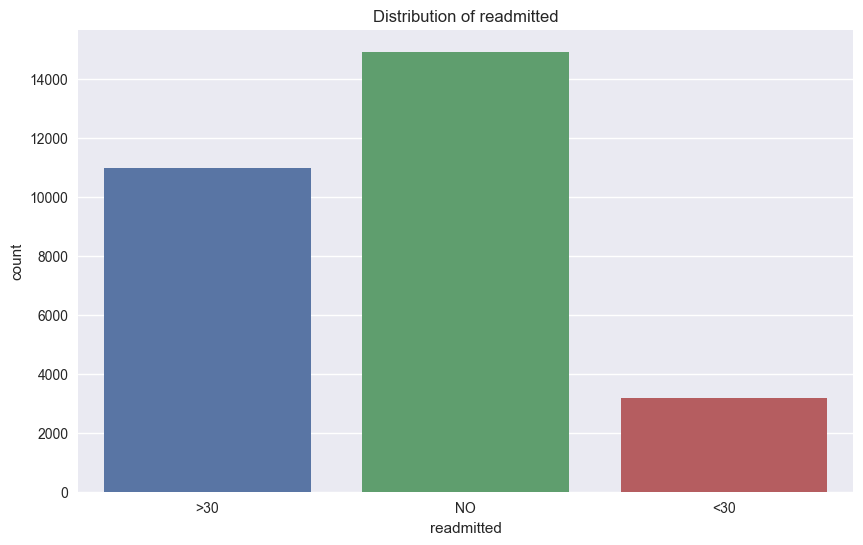

In [32]:
categorical_cols = filtered_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print("\nFrequency count for column:", col)
    print(filtered_df[col].value_counts())
    plt.figure(figsize=(10,6))
    sns.countplot(data=filtered_df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

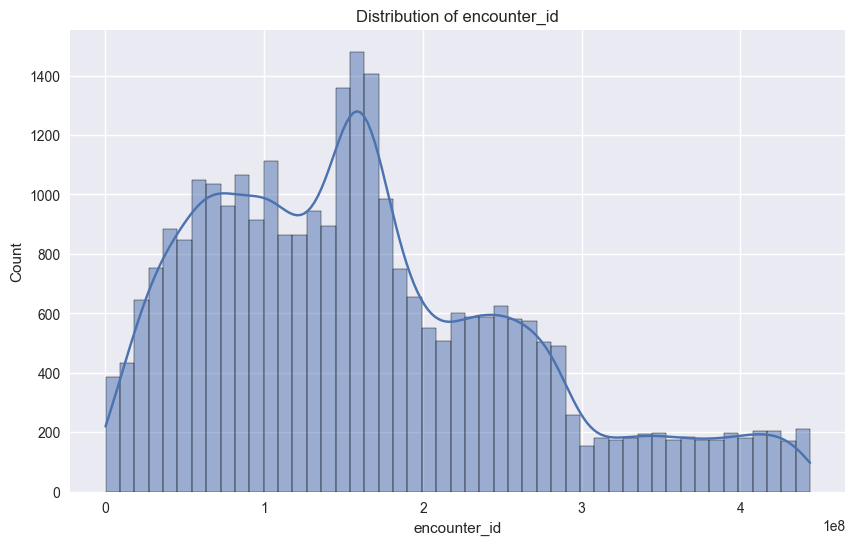

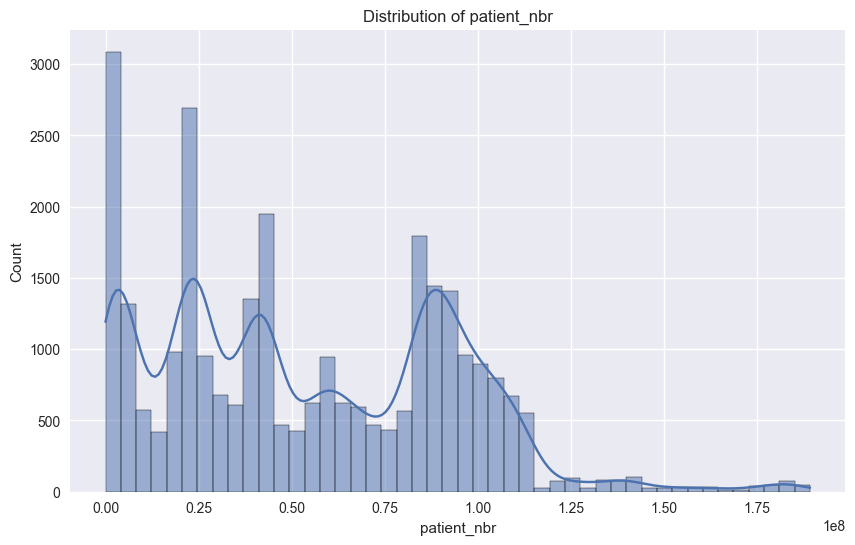

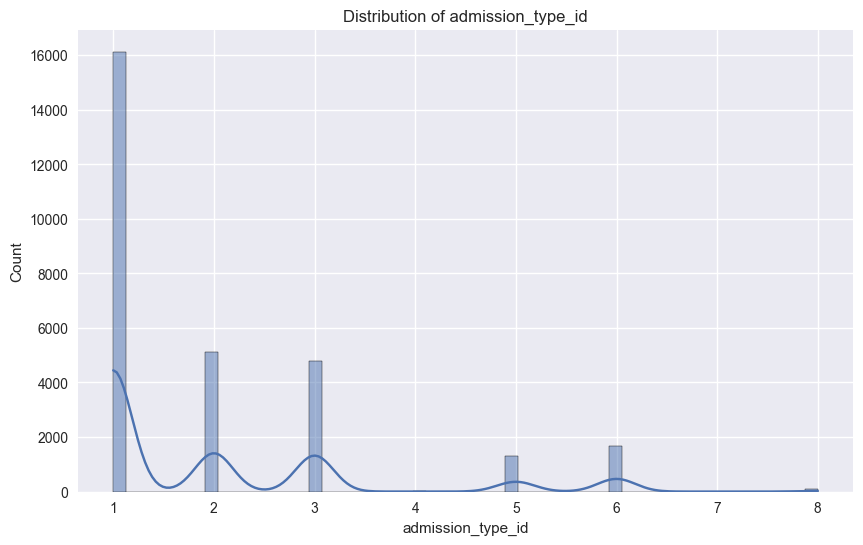

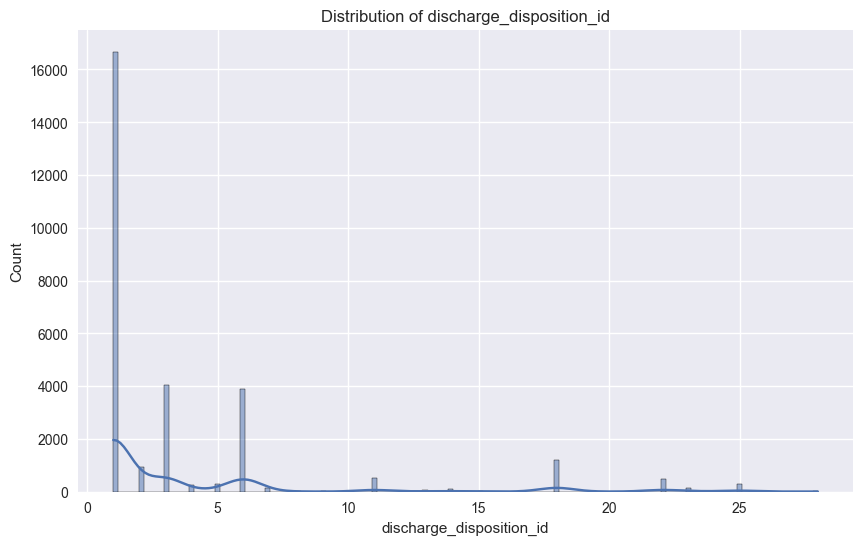

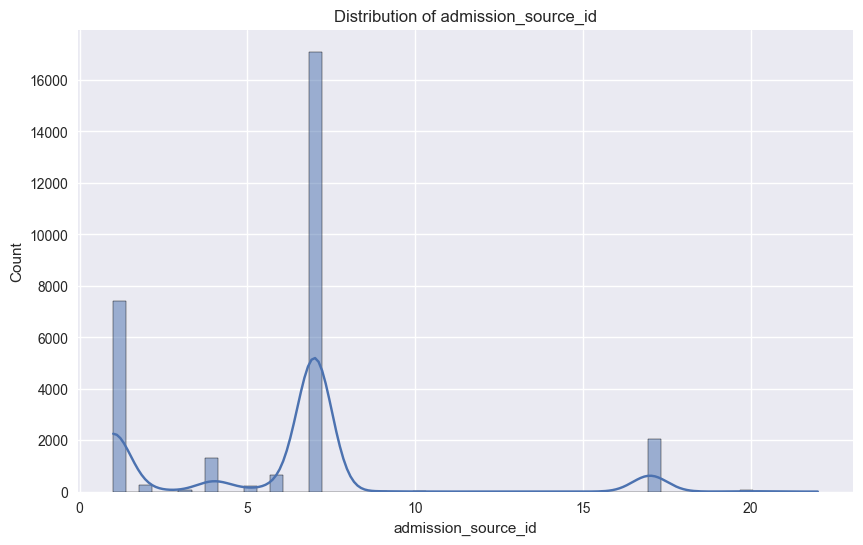

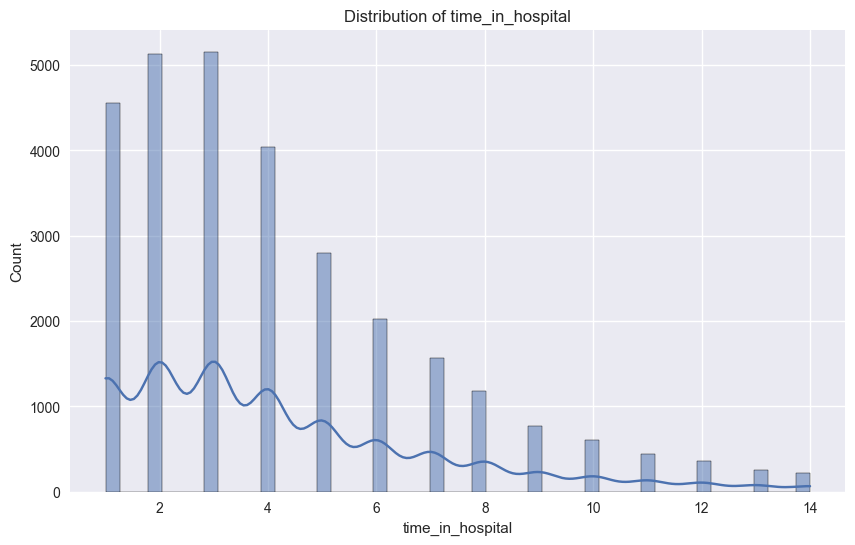

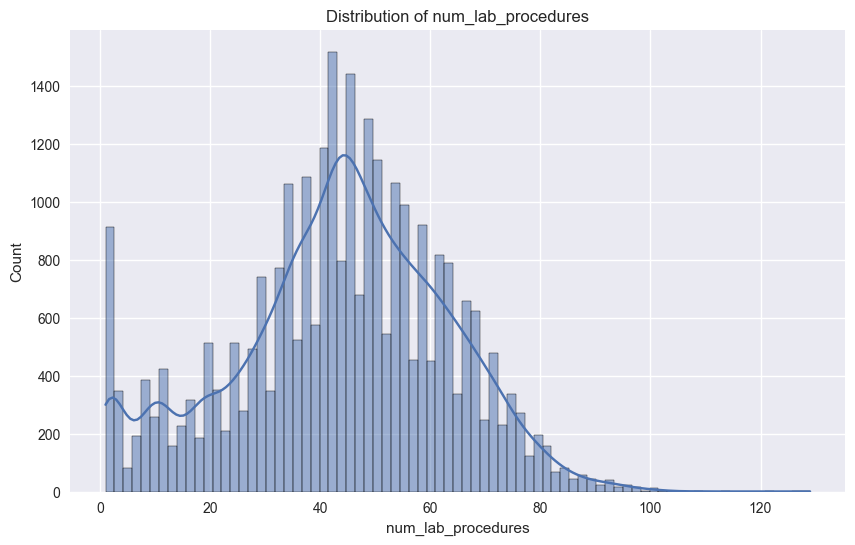

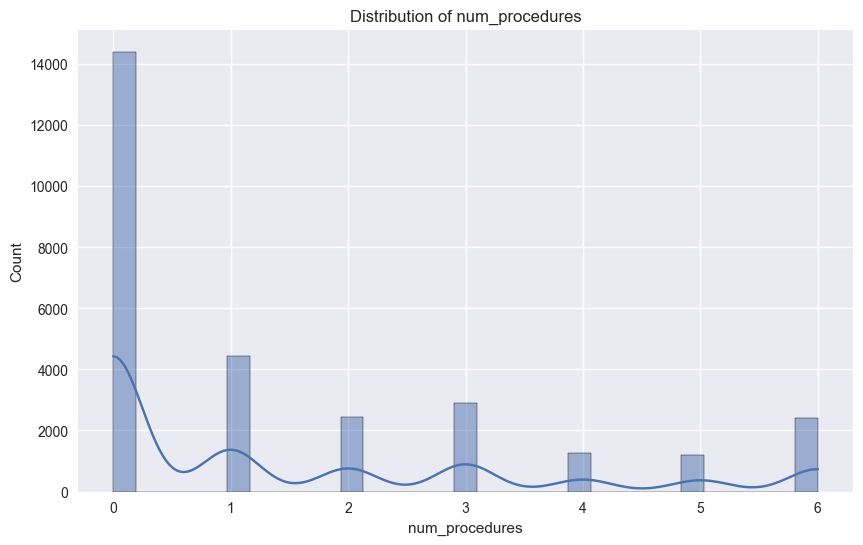

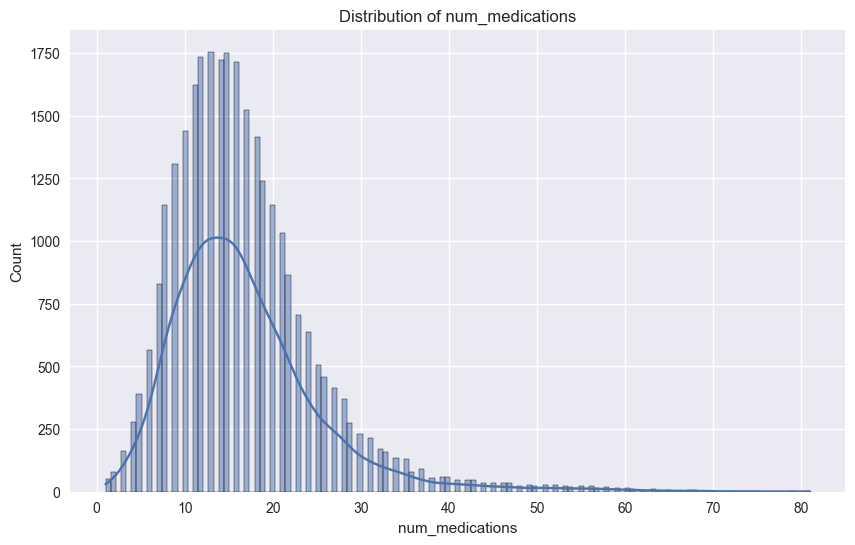

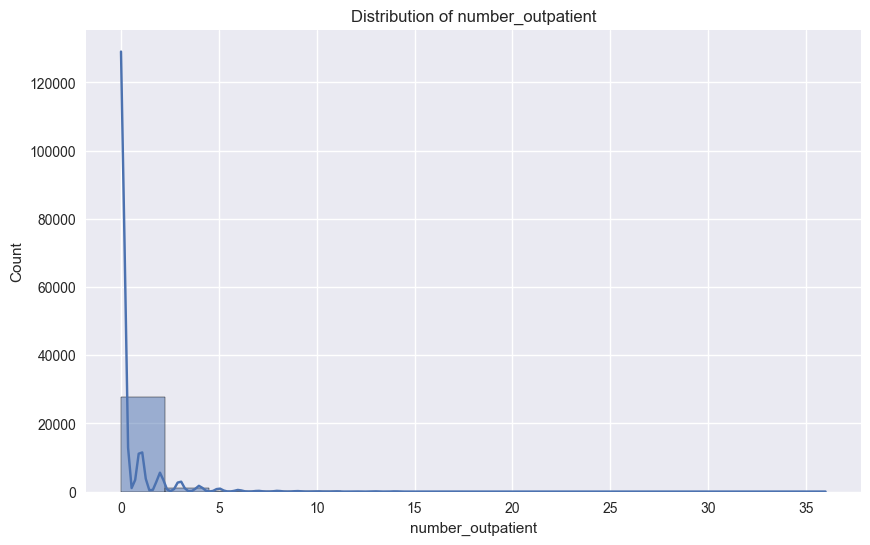

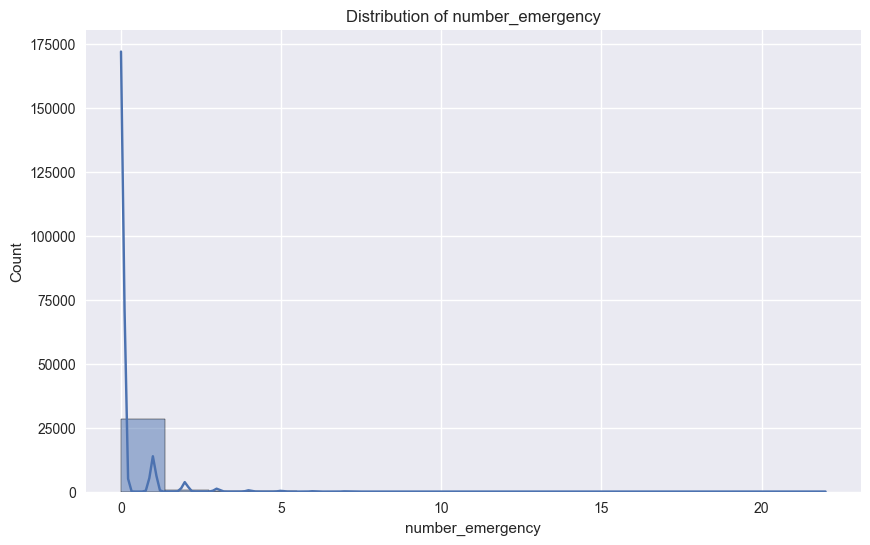

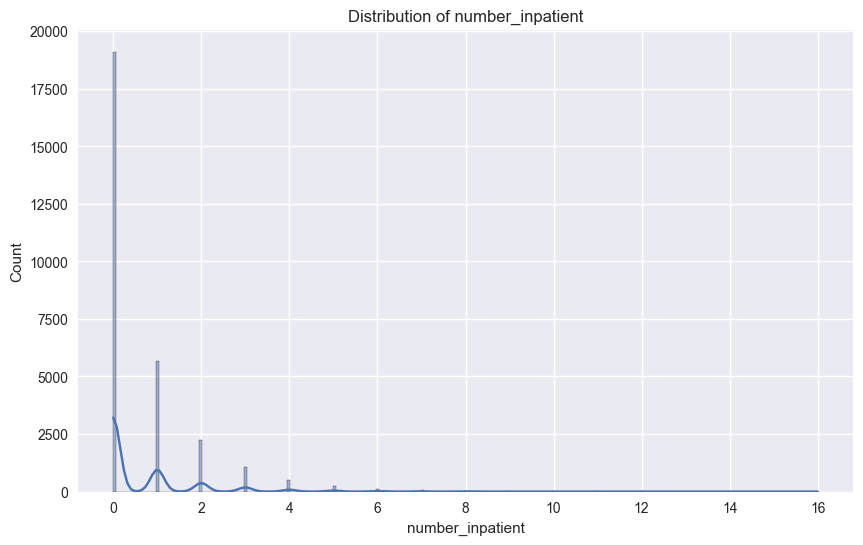

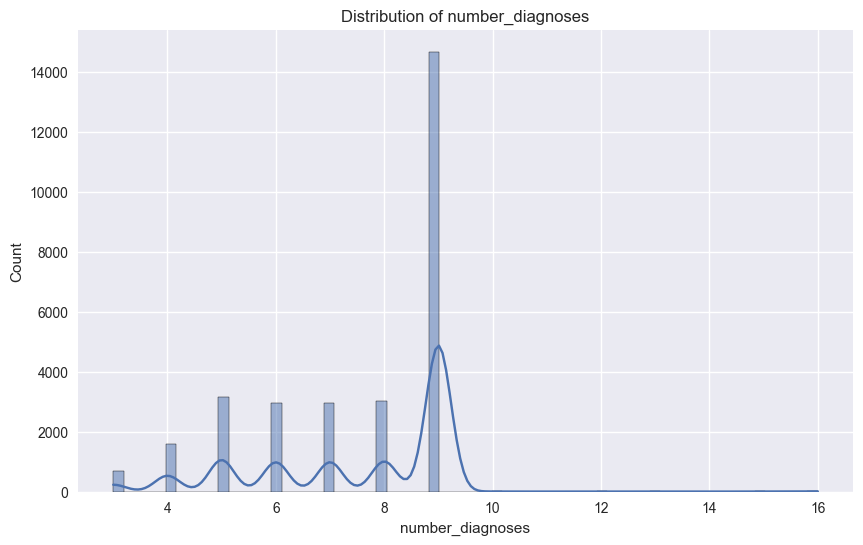

In [33]:
numerical_cols = filtered_df.select_dtypes(exclude=['object']).columns
for col in numerical_cols:
    plt.figure(figsize=(10,6))
    sns.histplot(data=filtered_df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

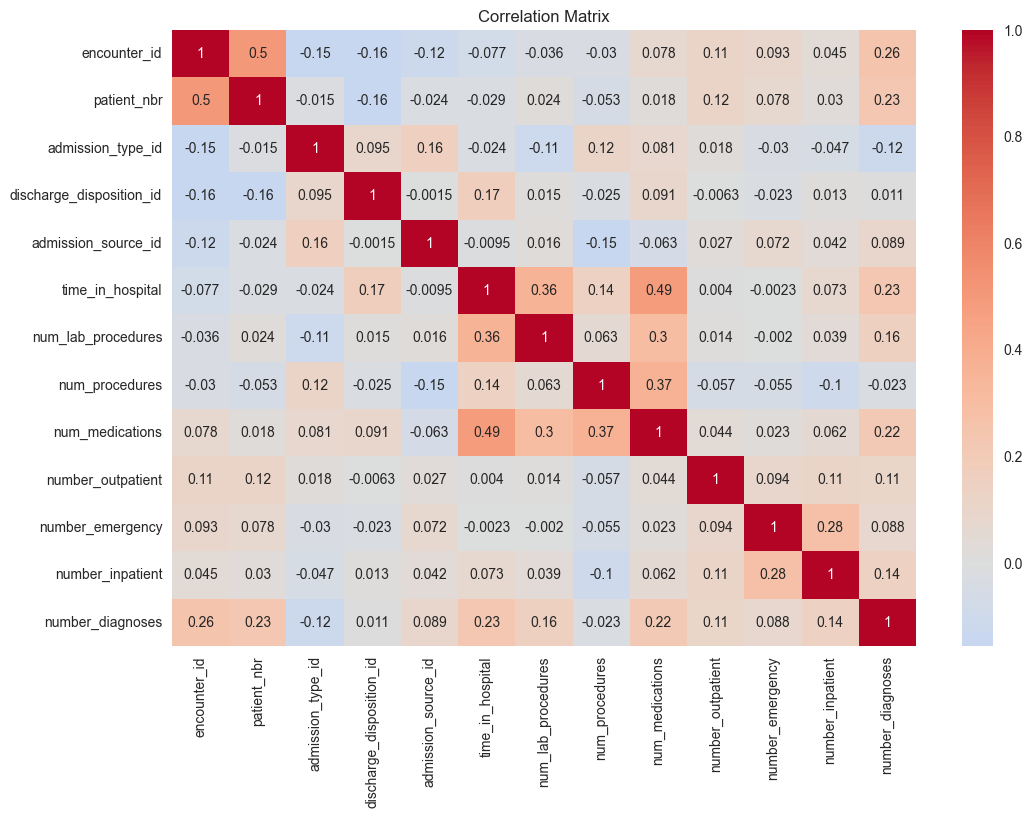

In [34]:
plt.figure(figsize=(12,8))
sns.heatmap(filtered_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

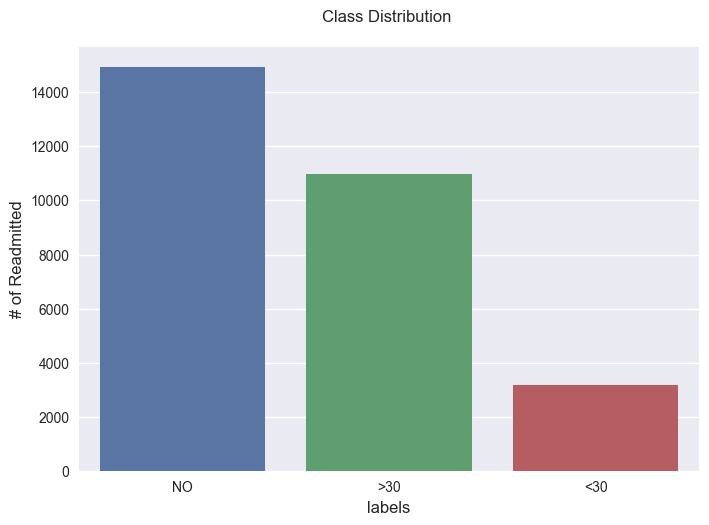

In [35]:
ax = sns.barplot(x=filtered_df['readmitted'].value_counts().index,   y=filtered_df['readmitted'].value_counts())
plt.xlabel('labels', size = 12)
plt.ylabel('# of Readmitted', size = 12)
plt.title('Class Distribution \n', size = 12)
plt.show()

In [36]:
# Created another column and take it as 2 class problem, Label the <30 and >30 as YES and Other "N0" as No.

def check_label(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'
    
filtered_df['readmitted_2'] =filtered_df['readmitted'].apply(check_label) 

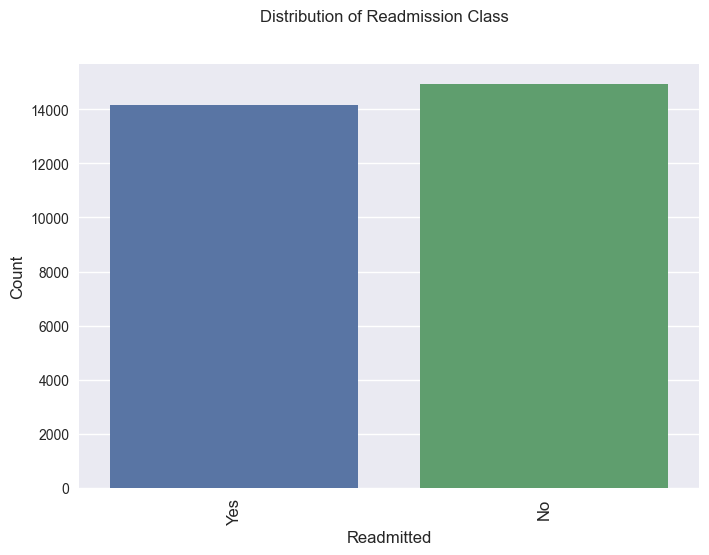

In [37]:
ax = sns.countplot(x='readmitted_2',   data= filtered_df)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

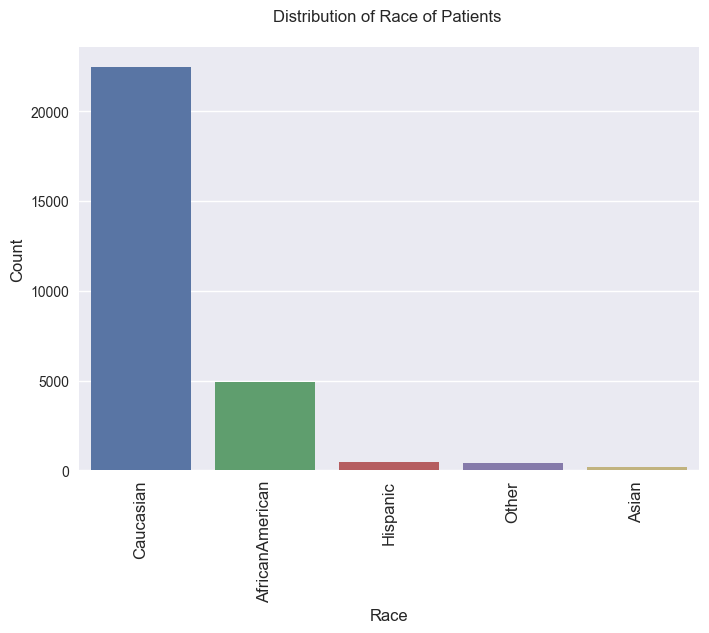

In [38]:
ax = sns.barplot(x=filtered_df['race'].value_counts().index,   y=filtered_df['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

The majority of the people are Caucasian, which are the people with european ancestry.

There are "?" in the data which means the race contains the Null values.

We will be needing to remove this from the data or we can also assign this with "Other" category

In [39]:
filtered_df.loc[filtered_df['race'] == '?', 'race'] = 'Other'

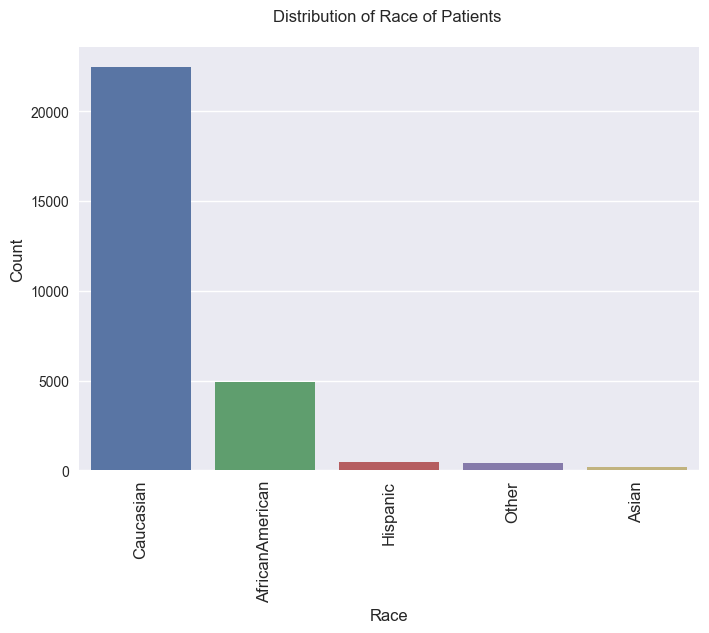

In [40]:
ax = sns.barplot(x=filtered_df['race'].value_counts().index,   y=filtered_df['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

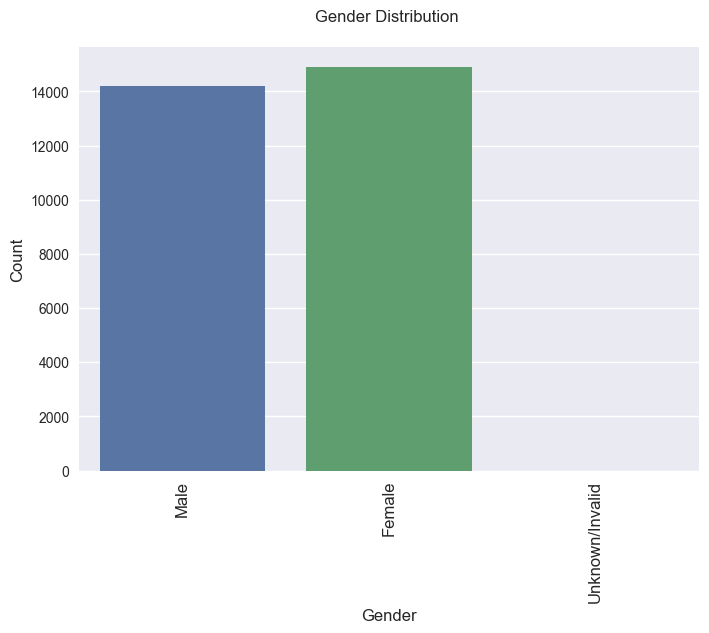

In [41]:
ax = sns.countplot(x='gender',   data= filtered_df)
plt.xlabel('Gender', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Gender Distribution \n', size = 12)
plt.show()

In [42]:
filtered_df['gender'].value_counts()

Female             14891
Male               14197
Unknown/Invalid        1
Name: gender, dtype: int64

In [43]:
filtered_df[filtered_df['gender']!='Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_2
5,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,...,Steady,No,No,No,No,No,No,Yes,>30,Yes
6,55842,84259809,Caucasian,Male,[60-70),NaN,3,1,2,4,...,Steady,No,No,No,No,No,Ch,Yes,NO,No
13,42570,77586282,Caucasian,Male,[80-90),NaN,1,6,7,10,...,Steady,No,No,No,No,No,No,Yes,NO,No
16,77076,92519352,AfricanAmerican,Male,[50-60),NaN,1,1,7,4,...,Steady,No,No,No,No,No,Ch,Yes,<30,Yes
20,150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,...,Down,No,No,No,No,No,Ch,Yes,NO,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101743,443793668,47293812,Caucasian,Male,[80-90),NaN,1,13,7,3,...,Down,No,No,No,No,No,Ch,Yes,NO,No
101744,443793992,43686936,Caucasian,Female,[80-90),NaN,1,1,7,1,...,No,No,No,No,No,No,No,No,NO,No
101746,443797298,89955270,Caucasian,Male,[70-80),NaN,1,1,7,4,...,No,No,No,No,No,No,No,Yes,<30,Yes
101749,443816024,106392411,Caucasian,Female,[70-80),NaN,3,6,1,3,...,Steady,No,No,No,No,No,Ch,Yes,NO,No


In [44]:
# Drop the "Unknown/Invalid" gender of the data.
filtered_df.drop(filtered_df[filtered_df['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [45]:
filtered_df.reset_index(inplace = True, drop = True)

In [46]:
filtered_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_2
0,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,...,Steady,No,No,No,No,No,No,Yes,>30,Yes
1,55842,84259809,Caucasian,Male,[60-70),NaN,3,1,2,4,...,Steady,No,No,No,No,No,Ch,Yes,NO,No
2,42570,77586282,Caucasian,Male,[80-90),NaN,1,6,7,10,...,Steady,No,No,No,No,No,No,Yes,NO,No
3,77076,92519352,AfricanAmerican,Male,[50-60),NaN,1,1,7,4,...,Steady,No,No,No,No,No,Ch,Yes,<30,Yes
4,150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,...,Down,No,No,No,No,No,Ch,Yes,NO,No


In [47]:
# Check the distribution of 'race' groups
race_distribution = filtered_df['race'].value_counts()
print("Race distribution:\n", race_distribution)

Race distribution:
 Caucasian          22467
AfricanAmerican     4908
Hispanic             491
Other                420
Asian                160
Name: race, dtype: int64


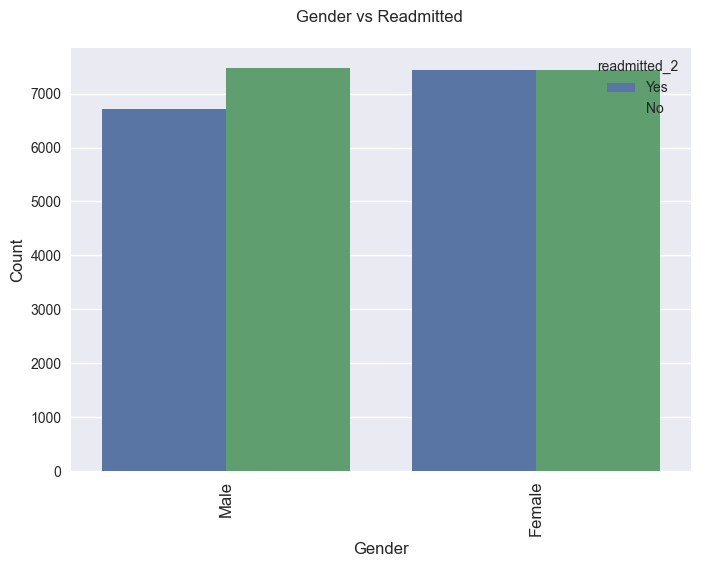

In [48]:
ax = sns.countplot(x="gender", hue="readmitted_2", data=filtered_df)
plt.xlabel('Gender', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Gender vs Readmitted \n', size = 12)
plt.show()

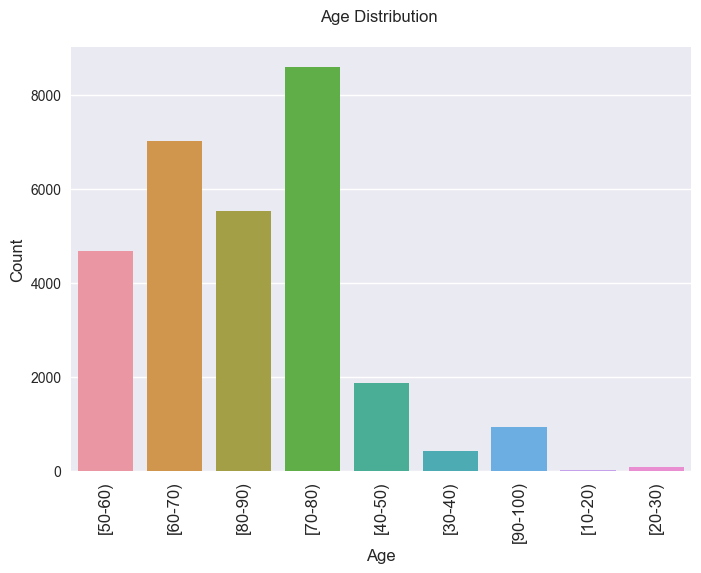

In [49]:
ax = sns.countplot(x='age',   data= filtered_df)
plt.xlabel('Age', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Age Distribution \n', size = 12)
plt.show()

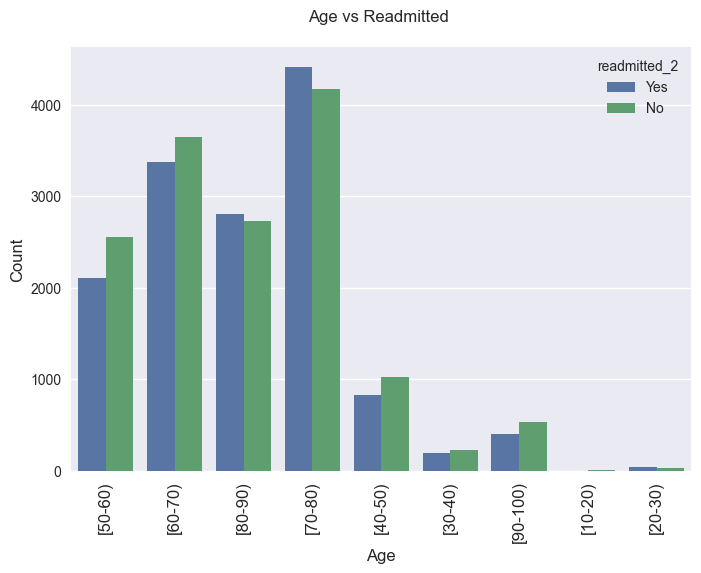

In [50]:
ax = sns.countplot(x="age", hue="readmitted_2", data=filtered_df)
plt.xlabel('Age', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Age vs Readmitted \n', size = 12)
plt.show()

The relationship of older Patients and Readmission is Strong as Mostly Older Patients are at high risk of Readmission.

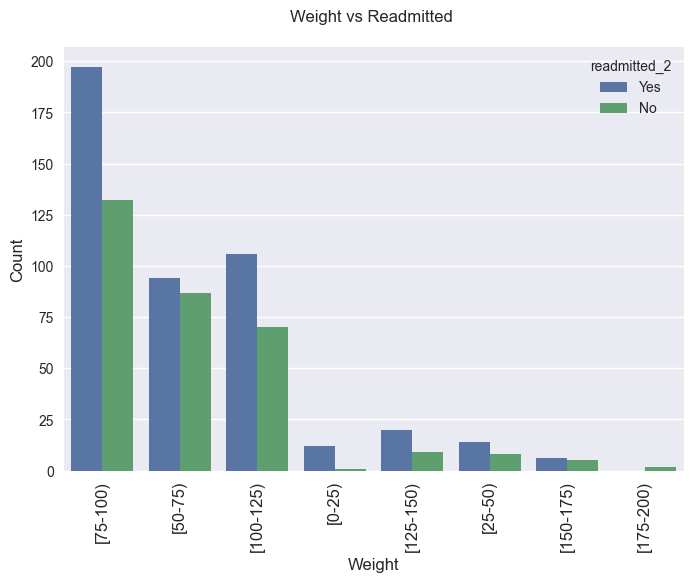

In [51]:
ax = sns.countplot(x="weight", hue="readmitted_2", data=filtered_df)
plt.xlabel('Weight', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Weight vs Readmitted \n', size = 12)
plt.show()

From value Counts We can see that the from around 101000 records, 98569 records dont have Weight Value.
So, We will drop this column.

In [52]:
# Lets drop this column. 
filtered_df.drop(columns = ['weight'], inplace = True)

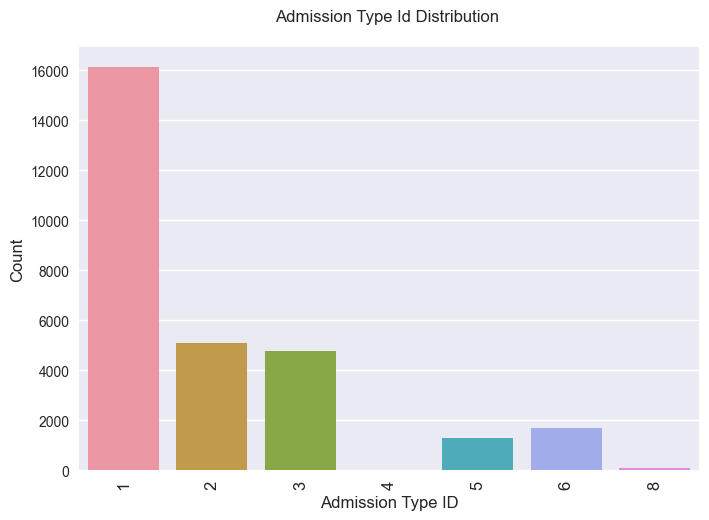

In [53]:
ax = sns.countplot(x='admission_type_id',   data= filtered_df)
plt.xlabel('Admission Type ID', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Admission Type Id Distribution \n', size = 12)
plt.show()

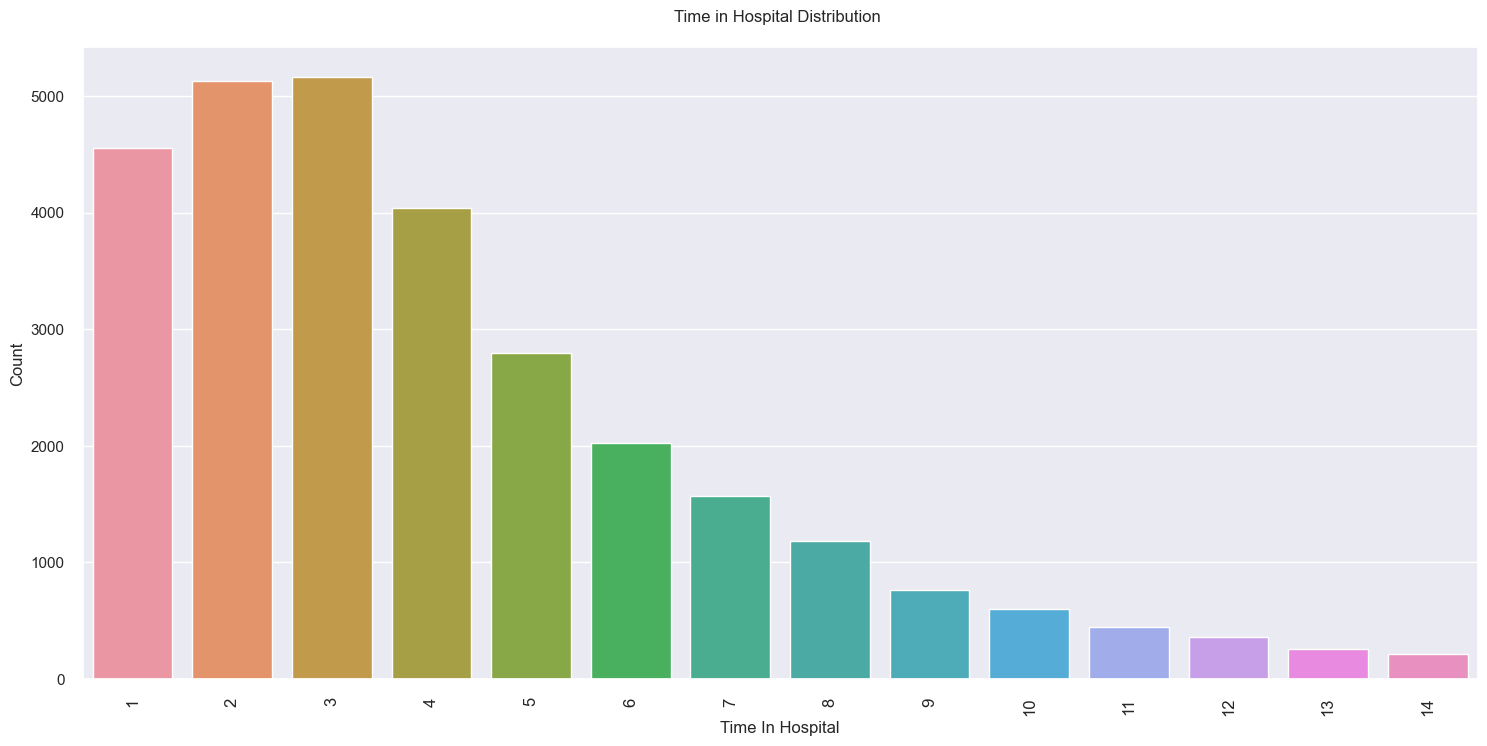

In [54]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='time_in_hospital',   data= filtered_df)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Time in Hospital Distribution \n', size = 12)
plt.show()

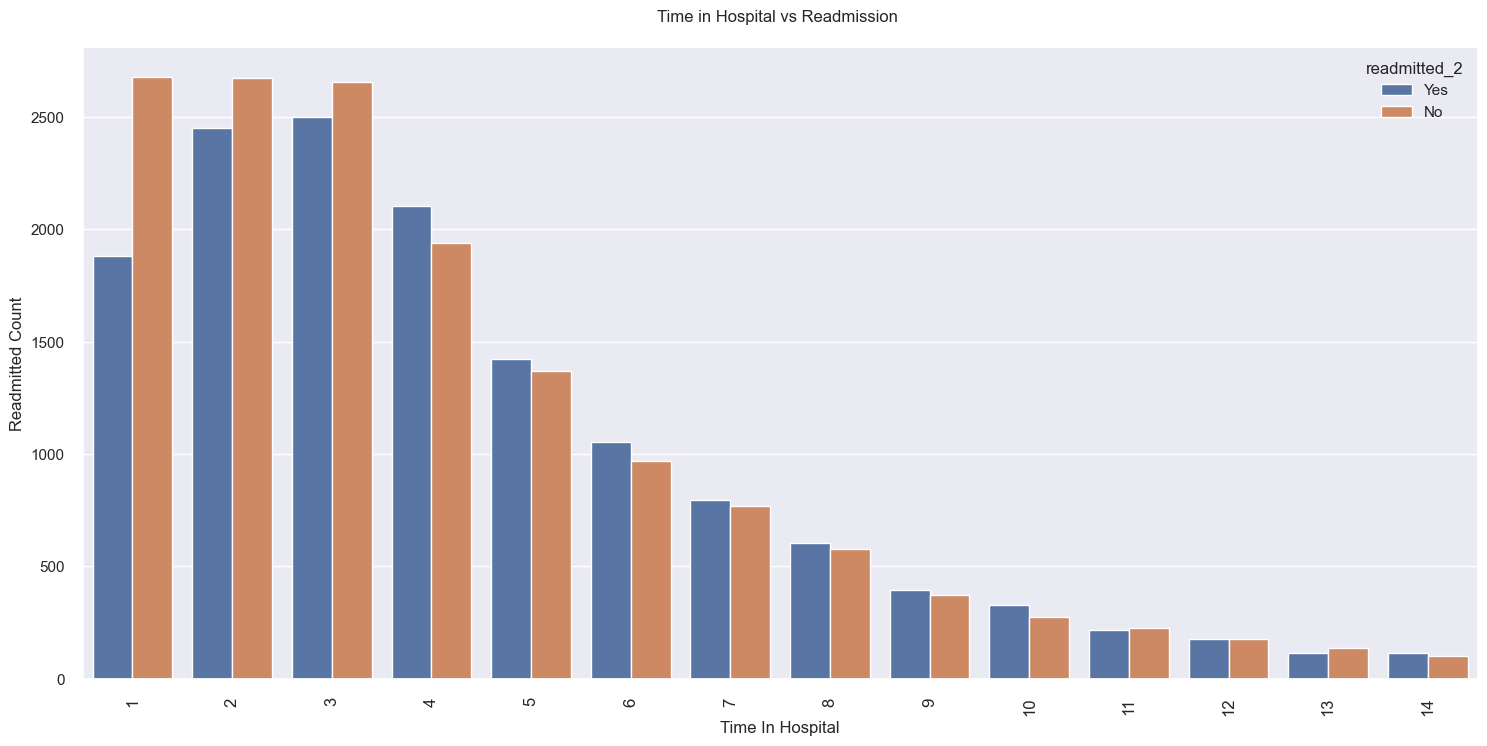

In [55]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='time_in_hospital',  hue= 'readmitted_2',  data= filtered_df)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Time in Hospital vs Readmission \n', size = 12)
plt.show()

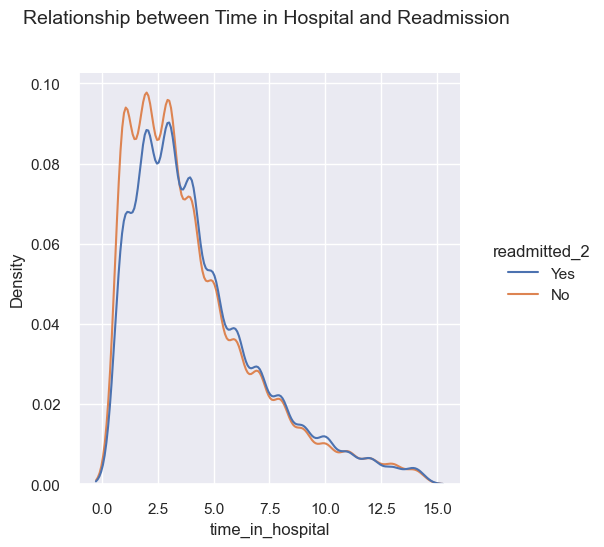

In [56]:
sns.set(rc={'figure.figsize':(18, 8.2)})
sns.displot(filtered_df, x="time_in_hospital", hue = 'readmitted_2', kind="kde")
plt.title('Relationship between Time in Hospital and Readmission \n\n', size  = 14)
plt.show()

In [57]:
filtered_df.drop(columns = ['payer_code'], inplace = True)

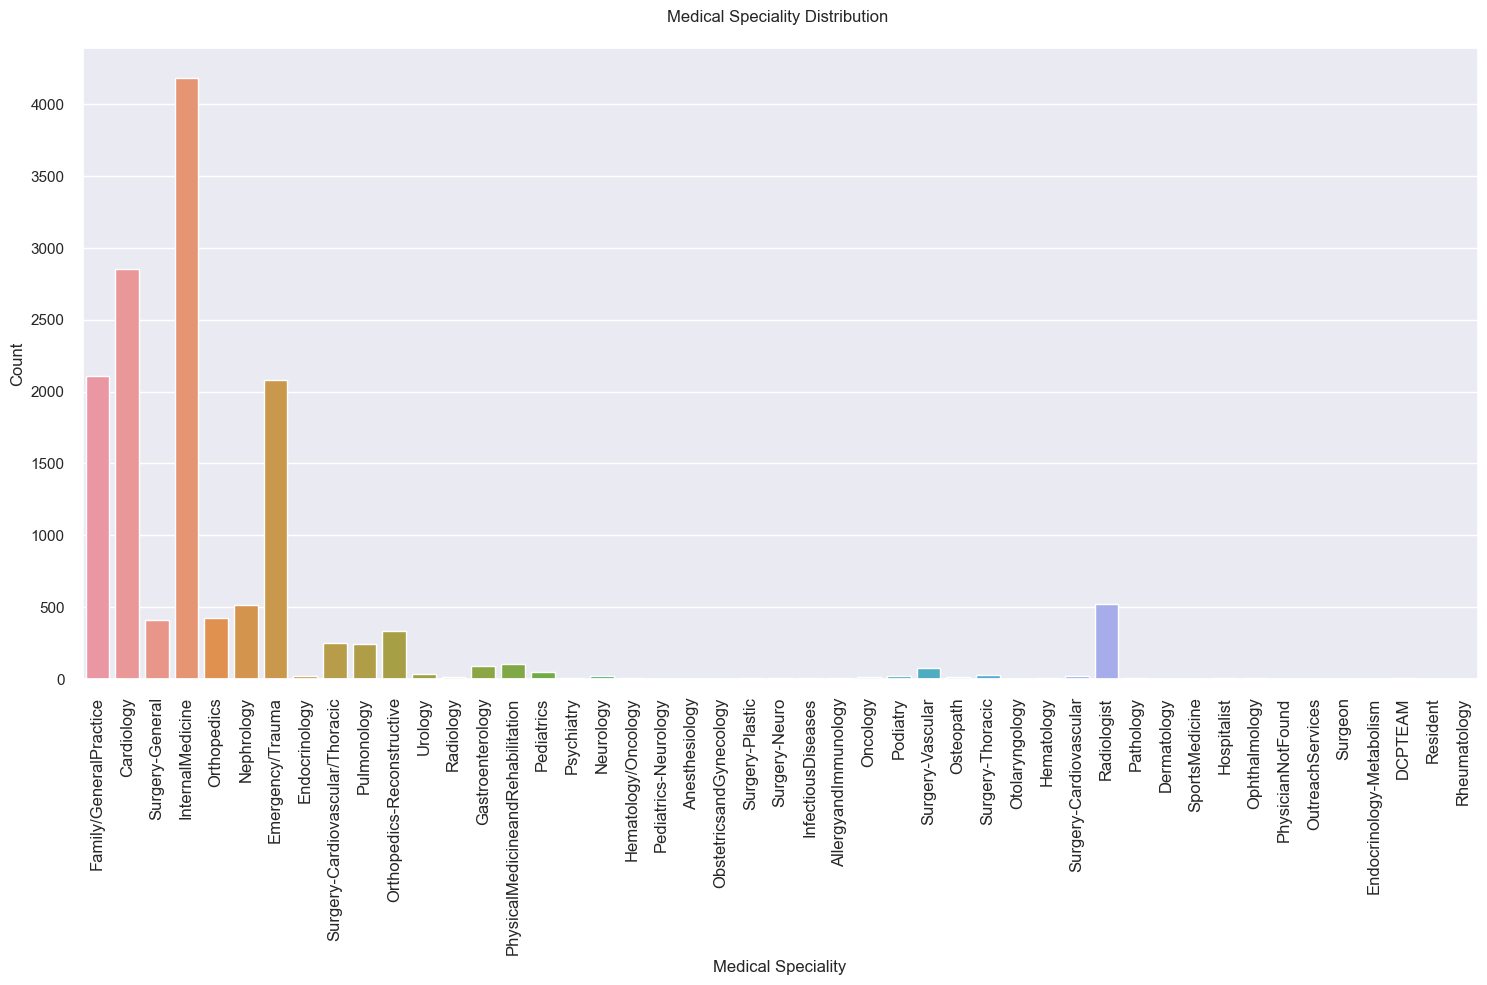

In [58]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='medical_specialty',   data= filtered_df)
plt.xlabel('Medical Speciality', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Medical Speciality Distribution \n', size = 12)
plt.show()

In [59]:
filtered_df.drop(columns =['medical_specialty'], inplace = True)

In [60]:
filtered_df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [61]:
filtered_df.shape

(29088, 38)

In [62]:
# Make copy of data.
filtered_df_ = filtered_df.copy()

In [63]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [64]:
categorical_features =['race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'] 

for i in categorical_features:
    filtered_df_[i] = le.fit_transform(filtered_df_[i])

In [65]:
filtered_df_.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted,readmitted_2
0,35754,82637451,2,1,4,1,0,1,3,31,...,1,1,0,0,2,0,1,1,>30,Yes
1,55842,84259809,2,1,5,2,0,1,4,70,...,1,1,0,0,2,0,0,1,NO,No
2,42570,77586282,2,1,7,0,5,6,10,55,...,1,1,0,0,2,0,1,1,NO,No
3,77076,92519352,0,1,4,0,0,6,4,45,...,1,1,0,0,2,0,0,1,<30,Yes
4,150006,22864131,5,0,4,1,0,3,2,66,...,1,1,0,0,0,0,0,1,NO,No


In [66]:
label = le.fit(filtered_df_['readmitted_2'])

In [67]:
filtered_df_['readmitted_2_encoded'] = label.transform(filtered_df_['readmitted_2'])

In [68]:
filtered_df_ = filtered_df_.drop(columns= ['encounter_id', 'patient_nbr', 'readmitted','readmitted_2'])

In [69]:
filtered_df_

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_2_encoded
0,2,1,4,1,0,1,3,31,6,16,...,1,1,1,0,0,2,0,1,1,1
1,2,1,5,2,0,1,4,70,1,21,...,1,1,1,0,0,2,0,0,1,0
2,2,1,7,0,5,6,10,55,1,31,...,1,1,1,0,0,2,0,1,1,0
3,0,1,4,0,0,6,4,45,4,17,...,1,1,1,0,0,2,0,0,1,1
4,5,0,4,1,0,3,2,66,1,19,...,1,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29083,2,1,7,0,11,6,3,45,0,26,...,3,1,2,0,0,0,0,0,1,0
29084,2,0,7,0,0,6,1,49,0,12,...,1,1,1,0,0,1,0,1,0,0
29085,2,1,6,0,0,6,4,2,0,7,...,1,1,1,0,0,1,0,1,1,1
29086,2,0,6,2,5,0,3,27,1,29,...,1,1,1,0,0,2,0,0,1,0


In [70]:
# Check the distribution of 'race' groups
race_distribution = filtered_df_['race'].value_counts()
print("Race distribution:\n", race_distribution)

Race distribution:
 2    22467
0     4908
5      642
3      491
4      420
1      160
Name: race, dtype: int64


In [71]:
filtered_df_ = filtered_df_[filtered_df_['race'] != 5]

In [72]:
filtered_df_[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.361372,0.138469,0.492682,0.002334,-0.002166,0.072390,0.231089
num_lab_procedures,0.361372,1.000000,0.063483,0.296469,0.012824,-0.001408,0.040381,0.153773
num_procedures,0.138469,0.063483,1.000000,0.369311,-0.057084,-0.055288,-0.102262,-0.024610
num_medications,0.492682,0.296469,0.369311,1.000000,0.042910,0.022931,0.062135,0.213088
number_outpatient,0.002334,0.012824,-0.057084,0.042910,1.000000,0.094296,0.109883,0.107221
number_emergency,-0.002166,-0.001408,-0.055288,0.022931,0.094296,1.000000,0.275855,0.087112
number_inpatient,0.072390,0.040381,-0.102262,0.062135,0.109883,0.275855,1.000000,0.142237
number_diagnoses,0.231089,0.153773,-0.024610,0.213088,0.107221,0.087112,0.142237,1.000000


In [73]:
filtered_df_.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted_2_encoded'],
      dtype='object')

In [74]:
X = filtered_df_.drop(columns= ['readmitted_2_encoded'])
y = filtered_df_['readmitted_2_encoded']
A = filtered_df_['race']

In [75]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.20, 
    random_state=42)

In [76]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, A_train.shape , A_test.shape

((22756, 34), (5690, 34), (22756,), (5690,), (22756,), (5690,))

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

In [78]:
import xgboost
from sklearn.metrics import classification_report, roc_auc_score

# Train the XGBoost model
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [79]:
xgb_prediction = xgb.predict(X_test)

In [80]:
print(classification_report(y_test, xgb_prediction, target_names=['Not Readmitted', 'Readmitted']))

# Predict probabilities for the 'Readmitted' class
xgb_probs = xgb.predict_proba(X_test)[:,1]

# Compute and print the ROC-AUC score
auc_score = roc_auc_score(y_test, xgb_probs)
print("AUC Score:", auc_score)

                precision    recall  f1-score   support

Not Readmitted       0.63      0.65      0.64      2847
    Readmitted       0.64      0.62      0.63      2843

      accuracy                           0.63      5690
     macro avg       0.63      0.63      0.63      5690
  weighted avg       0.63      0.63      0.63      5690

AUC Score: 0.6874132152609933


In [81]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43)

In [82]:
rf_prediction =  rf.predict(X_test)

In [83]:
print(classification_report(y_test, rf_prediction, target_names= ['Not Readmitted', 'Readmitted']))
# Predict probabilities for the 'Readmitted' class
rf_probs = rf.predict_proba(X_test)[:,1]

# Compute and print the ROC-AUC score
auc_score = roc_auc_score(y_test, rf_probs)
print("AUC Score:", auc_score)

                precision    recall  f1-score   support

Not Readmitted       0.61      0.73      0.67      2847
    Readmitted       0.66      0.54      0.60      2843

      accuracy                           0.63      5690
     macro avg       0.64      0.63      0.63      5690
  weighted avg       0.64      0.63      0.63      5690

AUC Score: 0.6964682943125549


In [84]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize CatBoost classifier
catboost = CatBoostClassifier(iterations=450, random_state=43,verbose=False)

# Train the classifier
catboost.fit(X_train, y_train)

# Make predictions
catboost_prediction = catboost.predict(X_test)

# Print the classification report
print("CatBoost Classifier:")
print(classification_report(y_test, catboost_prediction, target_names=['Not Readmitted', 'Readmitted']))

# Predict probabilities for the 'Readmitted' class
catboost_probs = catboost.predict_proba(X_test)[:, 1]

# Compute and print the ROC-AUC score
auc_score = roc_auc_score(y_test, catboost_probs)
print("AUC Score:", auc_score)


CatBoost Classifier:
                precision    recall  f1-score   support

Not Readmitted       0.63      0.68      0.65      2847
    Readmitted       0.65      0.61      0.63      2843

      accuracy                           0.64      5690
     macro avg       0.64      0.64      0.64      5690
  weighted avg       0.64      0.64      0.64      5690

AUC Score: 0.701393781903951


In [85]:
# set up model:
classifiers = [catboost,
               rf,
               xgb]

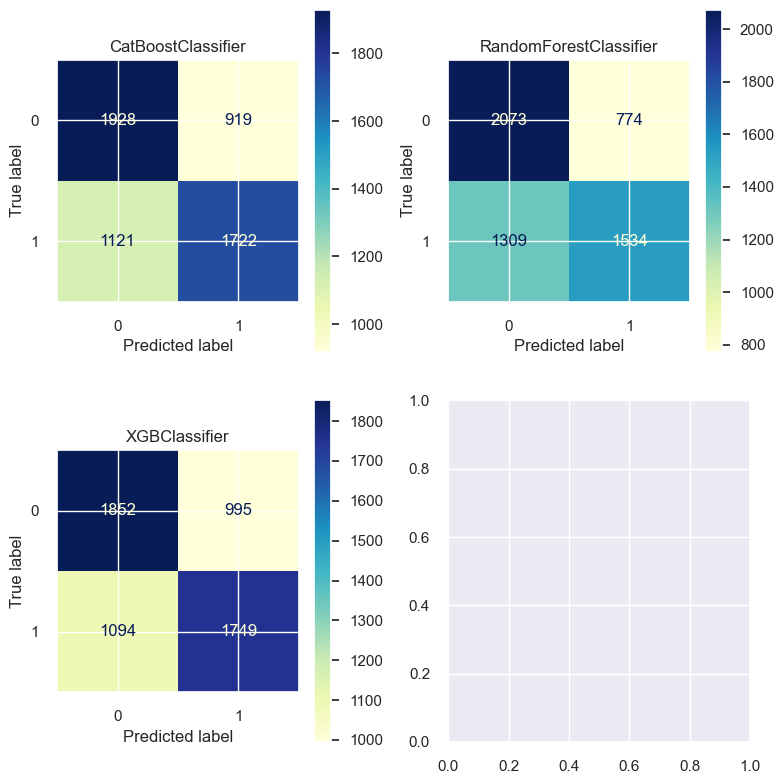

In [86]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

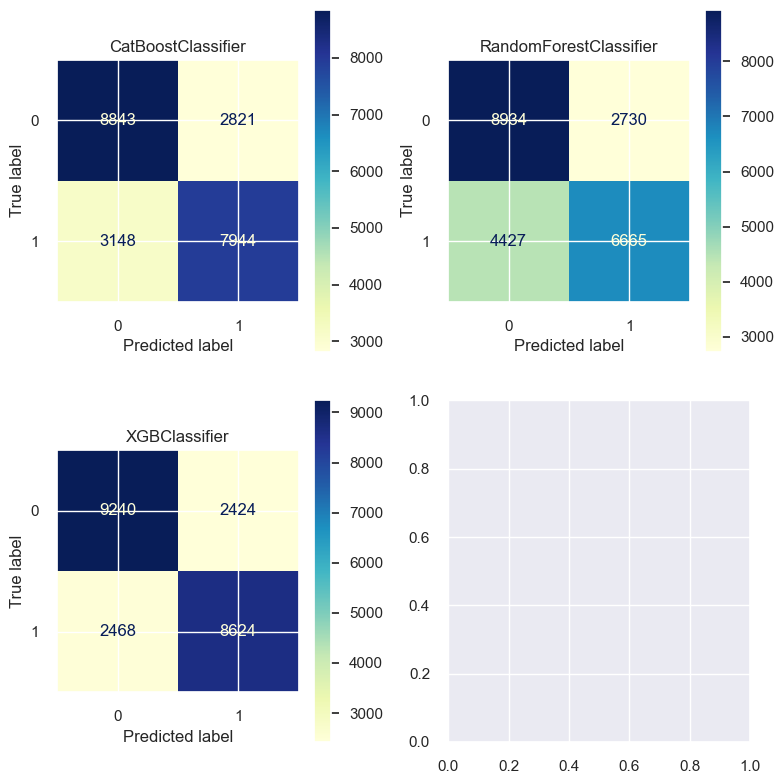

In [87]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [88]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}') 

<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
               precision    recall  f1-score   support

           0       0.63      0.68      0.65      2847
           1       0.65      0.61      0.63      2843

    accuracy                           0.64      5690
   macro avg       0.64      0.64      0.64      5690
weighted avg       0.64      0.64      0.64      5690

RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43): 
               precision    recall  f1-score   support

           0       0.61      0.73      0.67      2847
           1       0.66      0.54      0.60      2843

    accuracy                           0.63      5690
   macro avg       0.64      0.63      0.63      5690
weighted avg       0.64      0.63      0.63      5690

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
     

In [89]:
classification_report_aware = classification_report(y_test, y_pred)

In [90]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score



classifier_names = ["CatBoostClassifier", "RandomForestClassifier", "XGBoostClassifier"]

# Define the number of splits for cross-validation
n_splits = 4

# Loop over classifiers
for model, classifier_name in zip(classifiers, classifier_names):
    print(f"Evaluating {classifier_name}:")
    
    # Initialize lists to store classification reports and AUC scores
    classification_reports = []
    auc_scores = []
    
    # Perform cross-validation
    for train_index, test_index in StratifiedKFold(n_splits=n_splits).split(X_test, y_test):
        X_train_cv, X_test_cv = X_test.iloc[train_index], X_test.iloc[test_index]
        y_train_cv, y_test_cv = y_test.iloc[train_index], y_test.iloc[test_index]

        # Fit the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = model.predict(X_test_cv)

        # Predict probabilities for the 'Readmitted' class
        y_probs_cv = model.predict_proba(X_test_cv)[:, 1]

        # Compute the ROC-AUC score
        auc_cv = roc_auc_score(y_test_cv, y_probs_cv)
        auc_scores.append(auc_cv)

        # Generate and store the classification report
        report_cv = classification_report(y_test_cv, y_pred_cv, target_names=['Not Readmitted', 'Readmitted'], output_dict=True)
        classification_reports.append(report_cv)

    # Calculate the average AUC score across cross-validation folds
    avg_auc_score = sum(auc_scores) / len(auc_scores)
    
    # Calculate the average classification report across cross-validation folds
    avg_classification_report = {}
    for label in ['Not Readmitted', 'Readmitted']:
        avg_classification_report[label] = {
            'precision': sum(report[label]['precision'] for report in classification_reports) / len(classification_reports),
            'recall': sum(report[label]['recall'] for report in classification_reports) / len(classification_reports),
            'f1-score': sum(report[label]['f1-score'] for report in classification_reports) / len(classification_reports),
            'support': int(sum(report[label]['support'] for report in classification_reports) / len(classification_reports))
        }

    # Format and print the results
    print("Average Classification Report Aware of Race:")
    for label in avg_classification_report:
        print(f"{label}:")
        for metric in avg_classification_report[label]:
            print(f"{metric}: {avg_classification_report[label][metric]:.2f}")
        print()
    print(f"Average AUC Score: {avg_auc_score:.2f}")
    print("\n")

Evaluating CatBoostClassifier:
Average Classification Report Aware of Race:
Not Readmitted:
precision: 0.64
recall: 0.64
f1-score: 0.64
support: 711.00

Readmitted:
precision: 0.64
recall: 0.64
f1-score: 0.64
support: 710.00

Average AUC Score: 0.70


Evaluating RandomForestClassifier:
Average Classification Report Aware of Race:
Not Readmitted:
precision: 0.64
recall: 0.65
f1-score: 0.64
support: 711.00

Readmitted:
precision: 0.64
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69


Evaluating XGBoostClassifier:
Average Classification Report Aware of Race:
Not Readmitted:
precision: 0.62
recall: 0.62
f1-score: 0.62
support: 711.00

Readmitted:
precision: 0.62
recall: 0.63
f1-score: 0.62
support: 710.00

Average AUC Score: 0.67




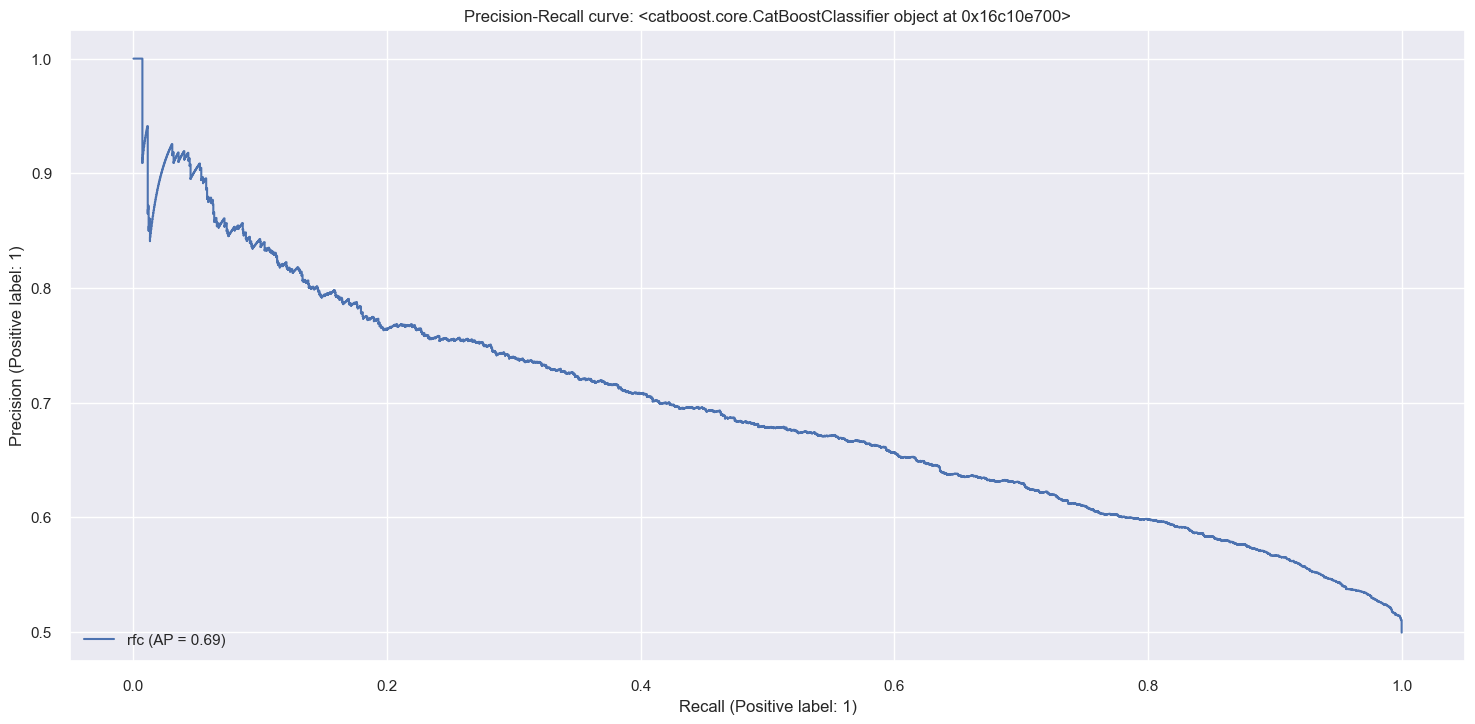

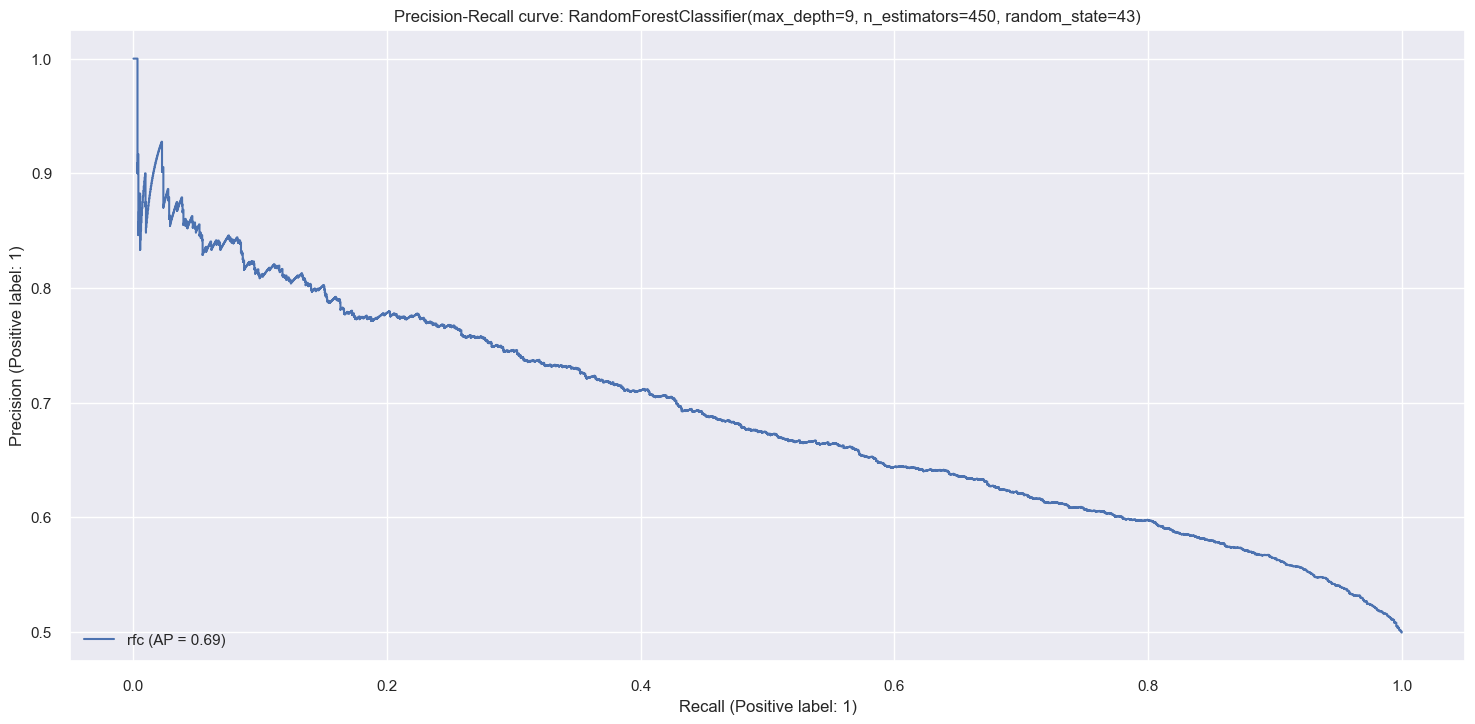

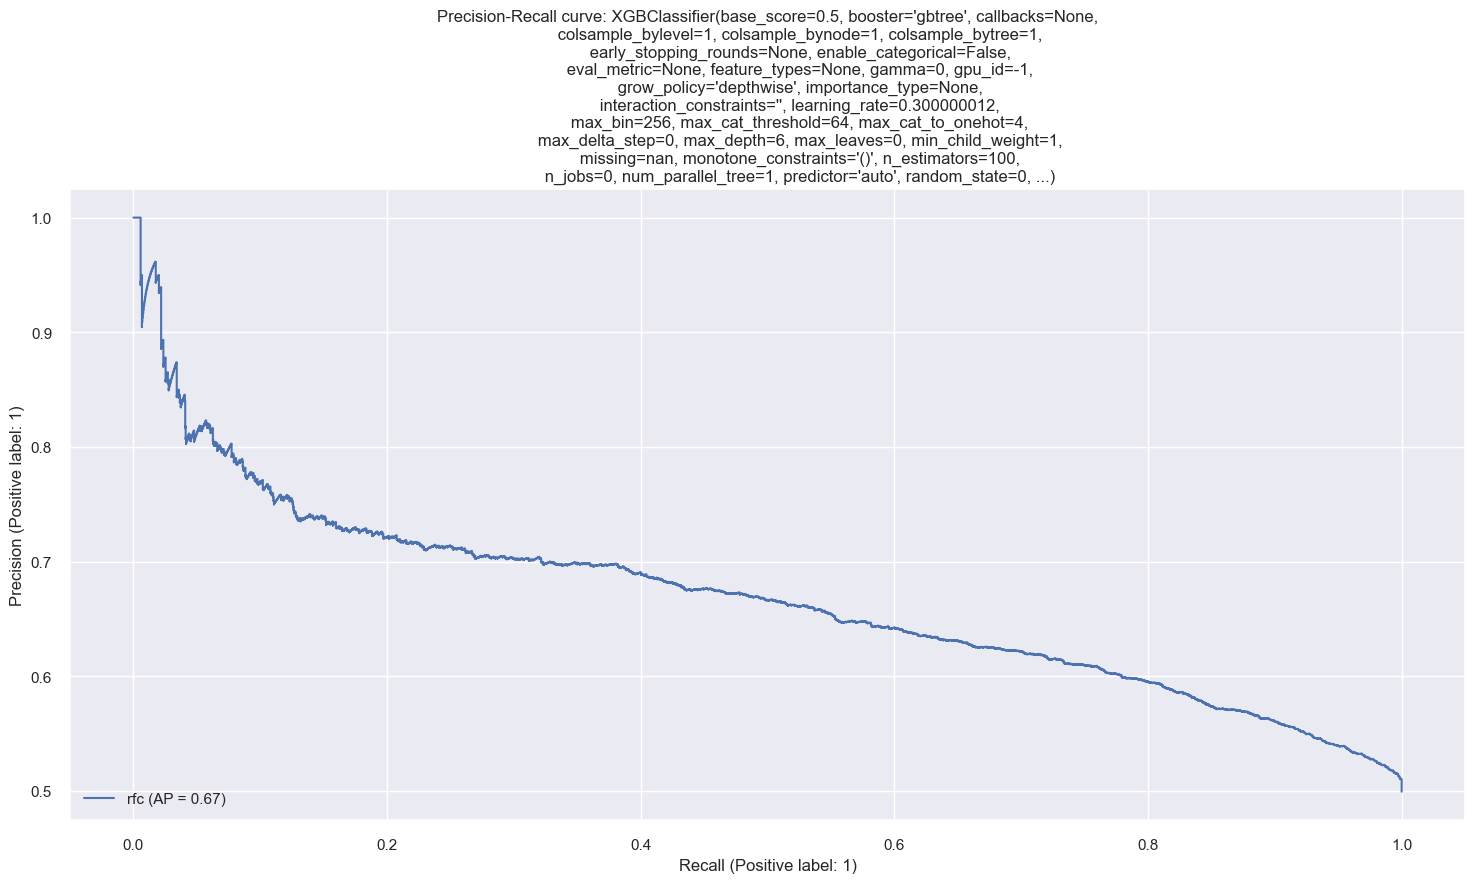

In [91]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')   

In [92]:
# define sensitive attributes
race =  A_test


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Race:{chr(10)}{model}: {chr(10)} {metric_frame (race)} {chr(10)}')

Race:
<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
            FPR       FNR       TPR       TNR
race                                        
0     0.291585  0.398833  0.601167  0.708415
1     0.312500  0.466667  0.533333  0.687500
2     0.365272  0.352836  0.647164  0.634728
3     0.232143  0.533333  0.466667  0.767857
4     0.195122  0.633333  0.366667  0.804878 

Race:
RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.281800  0.422179  0.577821  0.718200
1     0.250000  0.400000  0.600000  0.750000
2     0.340981  0.399732  0.600268  0.659019
3     0.232143  0.466667  0.533333  0.767857
4     0.317073  0.500000  0.500000  0.682927 

Race:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
       

In [93]:
# Define sensitive attributes
race = A_test

# Initialize lists to store the differences
difference_race1_and_2 = []
difference_race3_and_2 = []

# Metrics 
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores on test set
    y_pred = model.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"Aware-Unmitigated": (test_preds, y_pred)}

    # Calculate the TPR for each race group
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 5

    # Calculate and store the differences
    diff1_and_2 = tpr_race2 - tpr_race1
    diff3_and_2 = tpr_race2 - tpr_race3

    difference_race1_and_2.append(diff1_and_2)
    difference_race3_and_2.append(diff3_and_2)

    print(f'Race:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}') 

    # Calculate Equal Opportunity Differences for the current classifier
    eod_race1_and_2 = diff1_and_2
    eod_race3_and_2 = diff3_and_2

    print(f'Equal Opportunity Difference between Races Asian and Caucasian: {eod_race1_and_2}')
    print(f'Equal Opportunity Difference between Races Hispanic and Caucasian: {eod_race3_and_2}')

# Calculate the overall Equal Opportunity Differences between races 1 and 2 and between races 3 and 2
eod_race1_and_2_avg = sum(difference_race1_and_2) / len(difference_race1_and_2)
eod_race3_and_2_avg = sum(difference_race3_and_2) / len(difference_race3_and_2)

# Print the average Equal Opportunity Differences
print(f'Average Equal Opportunity Difference between Races Asian and Caucasian: {eod_race1_and_2_avg}')
print(f'Average Equal Opportunity Difference between Races Hispanic and Caucasian: {eod_race3_and_2_avg}')



Race:
<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
                                Aware-Unmitigated
Equalized_odds_difference               0.280497
False negative rate difference          0.280497
Balanced error rate difference          0.069019
Demographic parity difference           0.239118
  ------                                        
Overall AUC                             0.701394
AUC difference                          0.169986 

Equal Opportunity Difference between Races Asian and Caucasian: 0.11383057912758676
Equal Opportunity Difference between Races Hispanic and Caucasian: 0.1804972457942534
Race:
RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43): 
                                Aware-Unmitigated
Equalized_odds_difference               0.108838
False negative rate difference          0.100268
Balanced error rate difference          0.083537
Demographic parity difference           0.104753
  ------                                     

# Reweighting on Top ICD-9 Codes

In [96]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)

pip install 'aif360[LawSchoolGPA]'


In [97]:


# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)
     



In [98]:
ds_aif = aif360.datasets.StandardDataset (filtered_df_, 
                                         label_name="readmitted_2_encoded",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['race'], 
                                         privileged_classes= [lambda x: x == 2],
                                         )

In [99]:

# test, train split
ds_train, ds_test = ds_aif.split([0.80], shuffle=True)

In [100]:

# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'race': 3}, {'race': 1}]
priv = [{'race': 2}]


# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [101]:

# check for metric before and after transforming 
# OG ds
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transpormed ds
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

In [102]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()
     

In [103]:
# Assuming race is the first column in the features
race_column_index = 0  # You should adjust this index to match the actual position of race in your features

# Getting value counts for the training dataset
race_counts_train = np.unique(ds_train.features[:, race_column_index], return_counts=True)

# Getting value counts for the test dataset
race_counts_test = np.unique(ds_test.features[:, race_column_index], return_counts=True)

# Combine the counts from both train and test datasets
total_race_counts = race_counts_train[1] + race_counts_test[1]

# If you want to print the counts
for race_value, count in zip(race_counts_train[0], total_race_counts):
    print(f"Race group {race_value}: {count}")


Race group 0.0: 5979
Race group 1.0: 22467


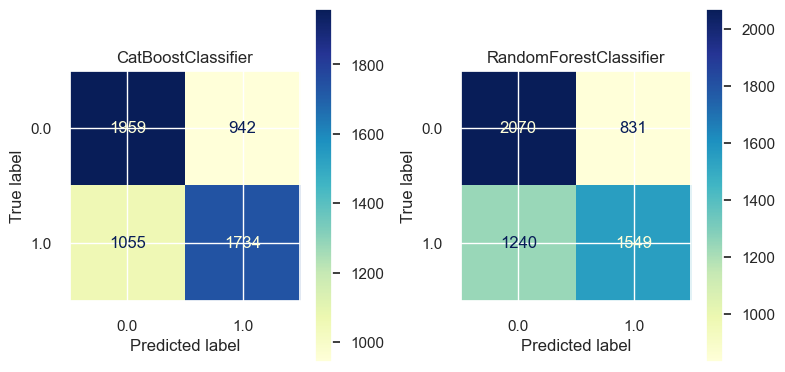

In [104]:

# test models with reweighted data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    y
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

In [105]:

for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
               precision    recall  f1-score   support

         0.0       0.65      0.68      0.66      2901
         1.0       0.65      0.62      0.63      2789

    accuracy                           0.65      5690
   macro avg       0.65      0.65      0.65      5690
weighted avg       0.65      0.65      0.65      5690

RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43): 
               precision    recall  f1-score   support

         0.0       0.63      0.71      0.67      2901
         1.0       0.65      0.56      0.60      2789

    accuracy                           0.64      5690
   macro avg       0.64      0.63      0.63      5690
weighted avg       0.64      0.64      0.63      5690

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
     

In [106]:
classification_report_reweighted = classification_report(y_test, y_pred)

In [107]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [108]:
for cls in classifiers:
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight=dataset.instance_weights)
    y_pred = cls.predict(X_test)

    # scores on test set
    ds_test_pred.scores = cls.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f'Race:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}')  # change age<> gender
    print(f'Race:{chr(10)}{cls}: {chr(10)} {metric_frame(race)} {chr(10)}')  # change age<> gender

    mf1 = MetricFrame(metrics=metrics,
                      y_true=y_test,
                      y_pred=y_pred,
                      sensitive_features=race)

    # The disaggregated metrics are stored in a pandas Series mf1.by_group:
    print(f"{cls}:\n {mf1.by_group}\n")
    print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")
    
    
    

    # Calculate Equal Opportunity Differences
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 3

    eod_race1_and_2 = tpr_race2 - tpr_race1
    eod_race3_and_2 = tpr_race2 - tpr_race3

    print(f"Equal Opportunity Difference between Races 1 and 2: {eod_race1_and_2}")
    print(f"Equal Opportunity Difference between Races 3 and 2: {eod_race3_and_2}")


Race:
<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
                                mitigated_pre-processing
Equalized_odds_difference                      0.328457
False negative rate difference                  0.14912
Balanced error rate difference                 0.165084
Demographic parity difference                  0.154111
  ------                                               
Overall AUC                                    0.648506
AUC difference                                 0.165084 

Race:
<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
            FPR       FNR       TPR       TNR
race                                        
0     0.328386  0.388889  0.611111  0.671614
1     0.000000  0.473684  0.526316  1.000000
2     0.328457  0.371714  0.628286  0.671543
3     0.283019  0.520833  0.479167  0.716981
4     0.219512  0.400000  0.600000  0.780488 

<catboost.core.CatBoostClassifier object at 0x16c10e700>:
       accuracy  false positive rate  false

In [109]:

# set test & train data & defining age as sensitive attribute - UNAWARE

X = filtered_df_.drop(columns=['race','readmitted_2_encoded'])
y = filtered_df_['readmitted_2_encoded']

A = filtered_df_['race']


# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 

    test_size = 0.20, 
    random_state=42)


from sklearn.metrics import accuracy_score, confusion_matrix

def demographic_parity(y_true, y_pred):
    return abs(sum(y_pred == 1) / len(y_pred) - sum(y_true == 1) / len(y_true))

def equal_opportunity(y_true, y_pred):
    tpr_pred = sum((y_true == 1) & (y_pred == 1)) / sum(y_true == 1)
    tpr_true = sum((y_true == 1) & (y_pred == 1)) / sum(y_true == 1)
    return abs(tpr_pred - tpr_true)

def statistical_parity(y_true, y_pred):
    return abs(sum(y_pred == 1) / len(y_pred) - sum(y_true == 1) / len(y_true))

for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate fairness metrics
    dp = demographic_parity(y_test, y_pred)
    eo = equal_opportunity(y_test, y_pred)
    sp = statistical_parity(y_test, y_pred)
    
    print(f"Fairness Metrics for {type(model).__name__}:")
    print(f"Demographic Parity: {dp:.4f}")
    print(f"Equal Opportunity: {eo:.4f}")
    print(f"Statistical Parity: {sp:.4f}")
    print()

Fairness Metrics for CatBoostClassifier:
Demographic Parity: 0.0308
Equal Opportunity: 0.0000
Statistical Parity: 0.0308

Fairness Metrics for RandomForestClassifier:
Demographic Parity: 0.0796
Equal Opportunity: 0.0000
Statistical Parity: 0.0796

Fairness Metrics for XGBClassifier:
Demographic Parity: 0.0160
Equal Opportunity: 0.0000
Statistical Parity: 0.0160



In [110]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score



classifier_names = ["CatBoostClassifier", "RandomForestClassifier", "XGBoostClassifier"]

# Define the number of splits for cross-validation
n_splits = 4

# Loop over classifiers
for model, classifier_name in zip(classifiers, classifier_names):
    print(f"Evaluating {classifier_name}:")
    
    # Initialize lists to store classification reports and AUC scores
    classification_reports = []
    auc_scores = []
    
    # Perform cross-validation
    for train_index, test_index in StratifiedKFold(n_splits=n_splits).split(X_test, y_test):
        X_train_cv, X_test_cv = X_test.iloc[train_index], X_test.iloc[test_index]
        y_train_cv, y_test_cv = y_test.iloc[train_index], y_test.iloc[test_index]

        # Fit the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = model.predict(X_test_cv)

        # Predict probabilities for the 'Readmitted' class
        y_probs_cv = model.predict_proba(X_test_cv)[:, 1]

        # Compute the ROC-AUC score
        auc_cv = roc_auc_score(y_test_cv, y_probs_cv)
        auc_scores.append(auc_cv)

        # Generate and store the classification report
        report_cv = classification_report(y_test_cv, y_pred_cv, target_names=['Not Readmitted', 'Readmitted'], output_dict=True)
        classification_reports.append(report_cv)

    # Calculate the average AUC score across cross-validation folds
    avg_auc_score = sum(auc_scores) / len(auc_scores)
    
    # Calculate the average classification report across cross-validation folds
    avg_classification_report = {}
    for label in ['Not Readmitted', 'Readmitted']:
        avg_classification_report[label] = {
            'precision': sum(report[label]['precision'] for report in classification_reports) / len(classification_reports),
            'recall': sum(report[label]['recall'] for report in classification_reports) / len(classification_reports),
            'f1-score': sum(report[label]['f1-score'] for report in classification_reports) / len(classification_reports),
            'support': int(sum(report[label]['support'] for report in classification_reports) / len(classification_reports))
        }

    # Format and print the results
    print("Average Classification Report Unaware of Race:")
    for label in avg_classification_report:
        print(f"{label}:")
        for metric in avg_classification_report[label]:
            print(f"{metric}: {avg_classification_report[label][metric]:.2f}")
        print()
    print(f"Average AUC Score: {avg_auc_score:.2f}")
    print("\n")


Evaluating CatBoostClassifier:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.64
recall: 0.65
f1-score: 0.64
support: 711.00

Readmitted:
precision: 0.64
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69


Evaluating RandomForestClassifier:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.64
recall: 0.65
f1-score: 0.65
support: 711.00

Readmitted:
precision: 0.64
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69


Evaluating XGBoostClassifier:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.63
recall: 0.62
f1-score: 0.62
support: 711.00

Readmitted:
precision: 0.62
recall: 0.63
f1-score: 0.63
support: 710.00

Average AUC Score: 0.67




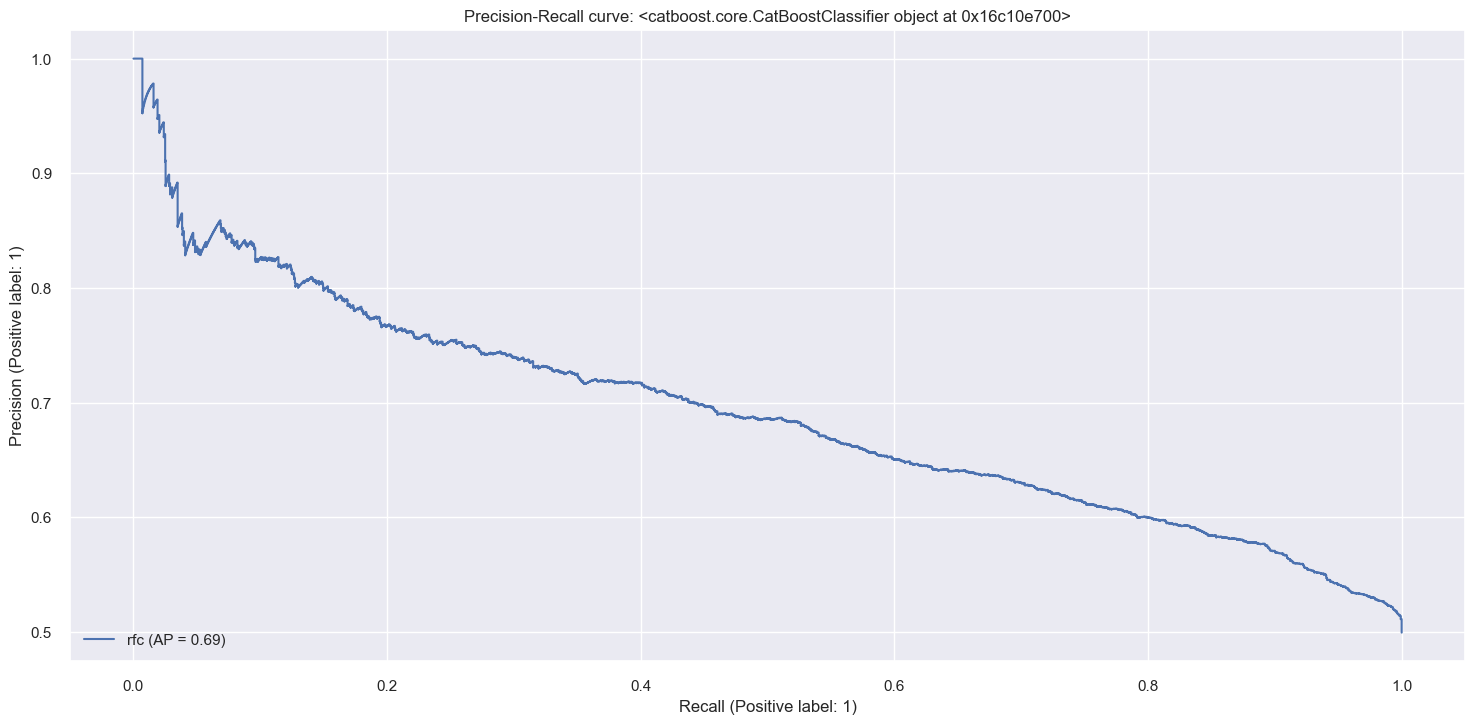

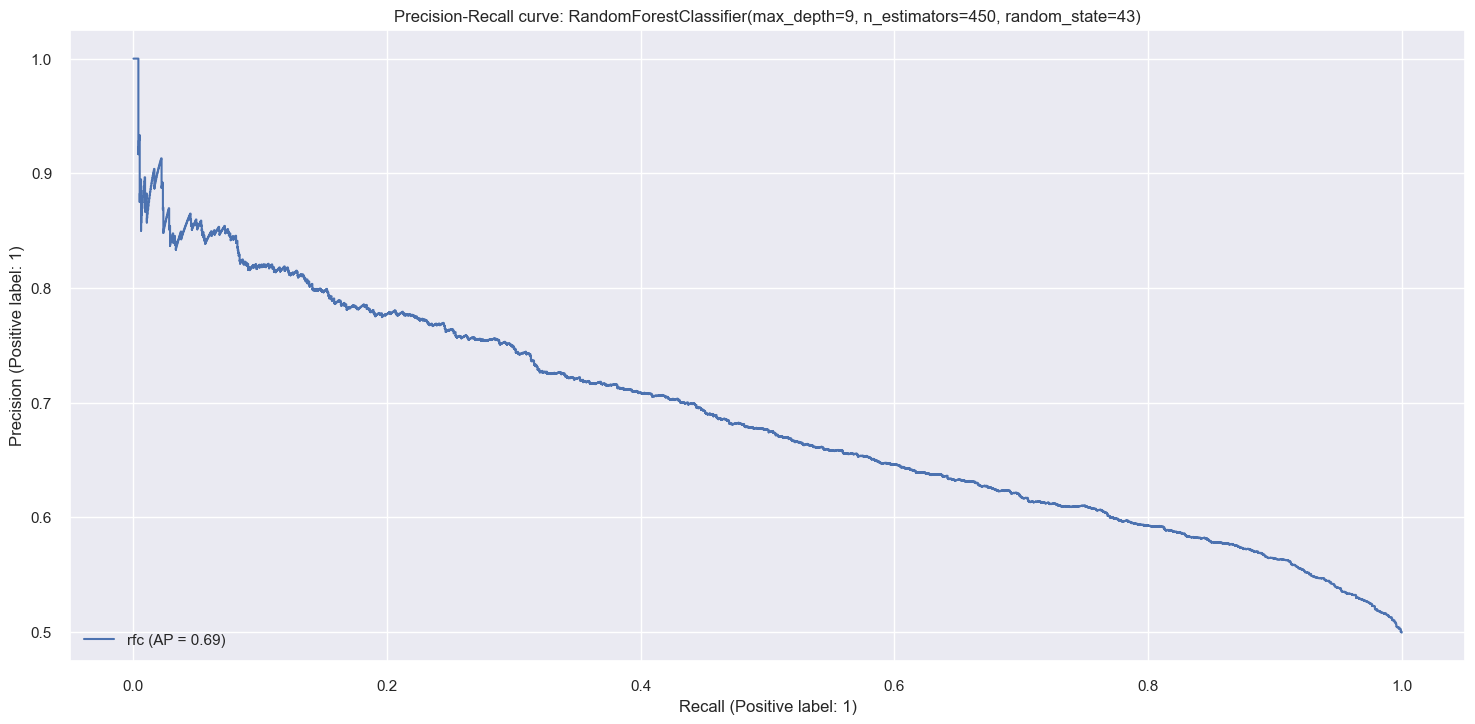

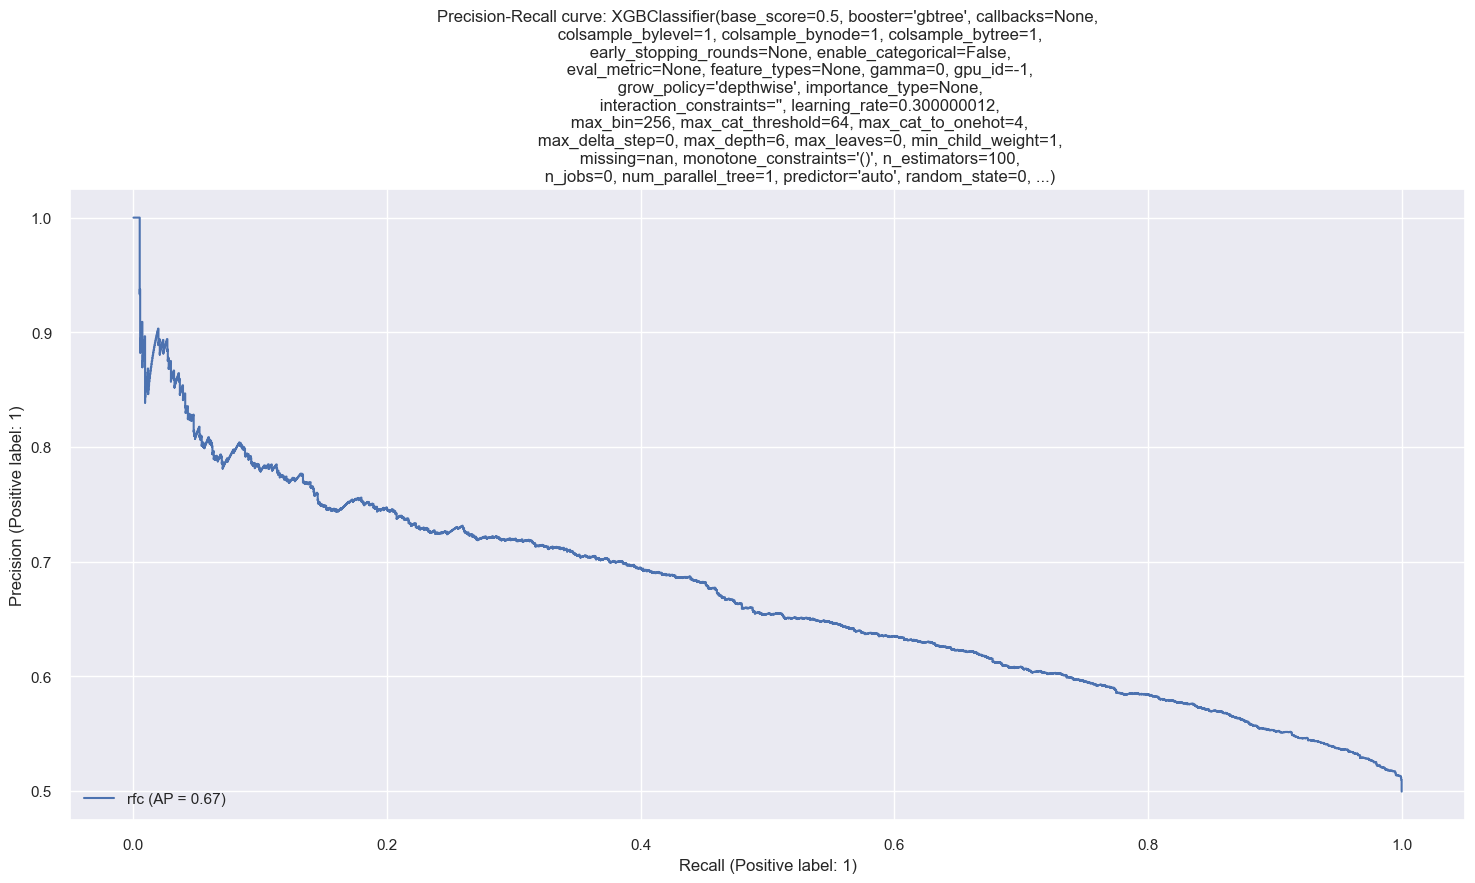

In [111]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')  

In [112]:
# define sensitive attributes
race =  A_test


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Race-Model is Unaware:{chr(10)}{model}: {chr(10)} {metric_frame (race)} {chr(10)}')

Race-Model is Unaware:
<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
            FPR       FNR       TPR       TNR
race                                        
0     0.330724  0.381323  0.618677  0.669276
1     0.375000  0.533333  0.466667  0.625000
2     0.359874  0.358196  0.641804  0.640126
3     0.303571  0.422222  0.577778  0.696429
4     0.365854  0.500000  0.500000  0.634146 

Race-Model is Unaware:
RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.297456  0.406615  0.593385  0.702544
1     0.312500  0.333333  0.666667  0.687500
2     0.349078  0.384993  0.615007  0.650922
3     0.285714  0.466667  0.533333  0.714286
4     0.341463  0.466667  0.533333  0.658537 

Race-Model is Unaware:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stop

In [113]:
# Define sensitive attributes
race = A_test

# Initialize lists to store the differences
difference_race1_and_2 = []
difference_race3_and_2 = []

# Metrics 
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores on test set
    y_pred = model.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"Unaware": (test_preds, y_pred)}

    # Calculate the TPR for each race group
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 5

    # Calculate and store the differences
    diff1_and_2 = tpr_race2 - tpr_race1
    diff3_and_2 = tpr_race2 - tpr_race3

    difference_race1_and_2.append(diff1_and_2)
    difference_race3_and_2.append(diff3_and_2)

    print(f'Race:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}') 

    # Calculate Equal Opportunity Differences for the current classifier
    eod_race1_and_2 = diff1_and_2
    eod_race3_and_2 = diff3_and_2

    print(f'Equal Opportunity Difference between Races 1 and 2: {eod_race1_and_2}')
    print(f'Equal Opportunity Difference between Races 3 and 2: {eod_race3_and_2}')



Race:
<catboost.core.CatBoostClassifier object at 0x16c10e700>: 
                                  Unaware
Equalized_odds_difference       0.175138
False negative rate difference  0.175138
Balanced error rate difference  0.098143
Demographic parity difference    0.08199
  ------                                
Overall AUC                     0.703221
AUC difference                  0.127913 

Equal Opportunity Difference between Races 1 and 2: 0.1751377102873306
Equal Opportunity Difference between Races 3 and 2: 0.06402659917621956
Race:
RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43): 
                                  Unaware
Equalized_odds_difference       0.133333
False negative rate difference  0.133333
Balanced error rate difference  0.081148
Demographic parity difference   0.087831
  ------                                
Overall AUC                     0.695549
AUC difference                  0.135772 

Equal Opportunity Difference between Races 1 and 2:

Fairness Metrics for CatBoostClassifier:
Demographic Parity: 0.0308
Equal Opportunity: 0.0000
Statistical Parity: 0.0308

Fairness Metrics for RandomForestClassifier:
Demographic Parity: 0.0796
Equal Opportunity: 0.0000
Statistical Parity: 0.0796

Fairness Metrics for XGBClassifier:
Demographic Parity: 0.0160
Equal Opportunity: 0.0000
Statistical Parity: 0.0160

Evaluating CatBoostClassifier:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.64
recall: 0.65
f1-score: 0.64
support: 711.00

Readmitted:
precision: 0.64
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69


Evaluating RandomForestClassifier:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.64
recall: 0.65
f1-score: 0.65
support: 711.00

Readmitted:
precision: 0.64
recall: 0.63
f1-score: 0.64
support: 710.00

Average AUC Score: 0.69


Evaluating XGBoostClassifier:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.63
recall: 0.62
f

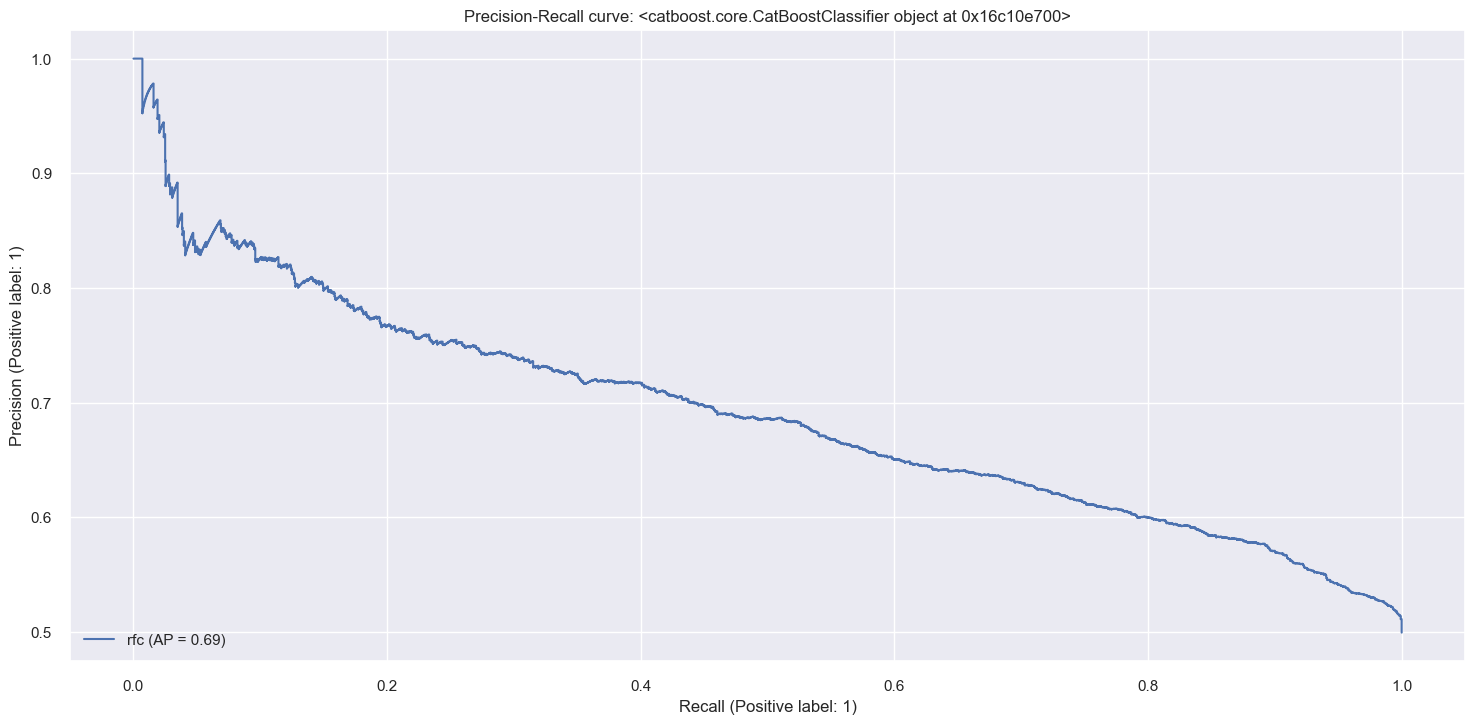

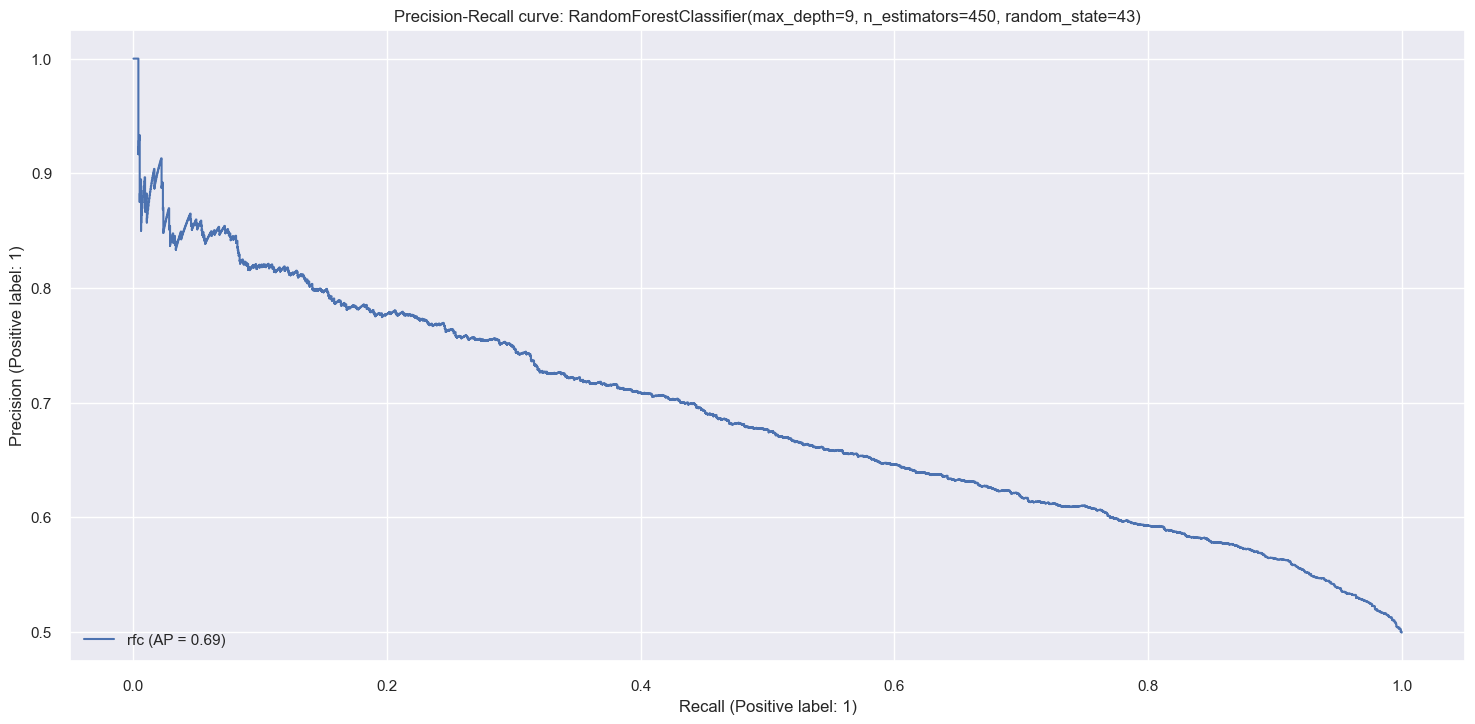

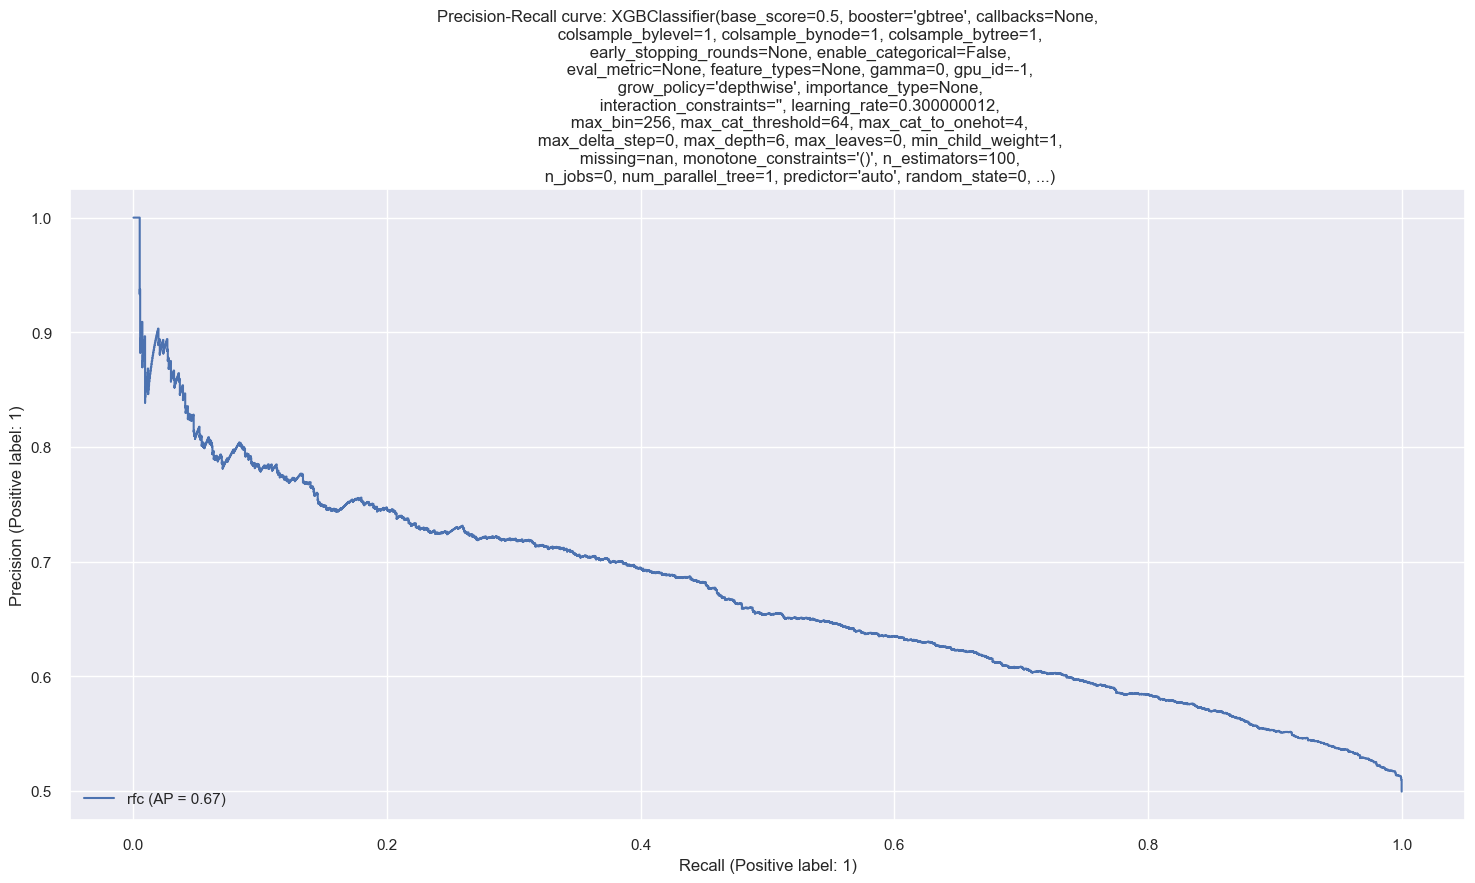

In [114]:

# set test & train data & defining age as sensitive attribute - UNAWARE

X = filtered_df_.drop(columns=['race','readmitted_2_encoded'])
y = filtered_df_['readmitted_2_encoded']

A = filtered_df_['race']


# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 

    test_size = 0.20, 
    random_state=42)


from sklearn.metrics import accuracy_score, confusion_matrix

def demographic_parity(y_true, y_pred):
    return abs(sum(y_pred == 1) / len(y_pred) - sum(y_true == 1) / len(y_true))

def equal_opportunity(y_true, y_pred):
    tpr_pred = sum((y_true == 1) & (y_pred == 1)) / sum(y_true == 1)
    tpr_true = sum((y_true == 1) & (y_pred == 1)) / sum(y_true == 1)
    return abs(tpr_pred - tpr_true)

def statistical_parity(y_true, y_pred):
    return abs(sum(y_pred == 1) / len(y_pred) - sum(y_true == 1) / len(y_true))

for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate fairness metrics
    dp = demographic_parity(y_test, y_pred)
    eo = equal_opportunity(y_test, y_pred)
    sp = statistical_parity(y_test, y_pred)
    
    print(f"Fairness Metrics for {type(model).__name__}:")
    print(f"Demographic Parity: {dp:.4f}")
    print(f"Equal Opportunity: {eo:.4f}")
    print(f"Statistical Parity: {sp:.4f}")
    print()

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score



classifier_names = ["CatBoostClassifier", "RandomForestClassifier", "XGBoostClassifier"]

# Define the number of splits for cross-validation
n_splits = 4

# Loop over classifiers
for model, classifier_name in zip(classifiers, classifier_names):
    print(f"Evaluating {classifier_name}:")
    
    # Initialize lists to store classification reports and AUC scores
    classification_reports = []
    auc_scores = []
    
    # Perform cross-validation
    for train_index, test_index in StratifiedKFold(n_splits=n_splits).split(X_test, y_test):
        X_train_cv, X_test_cv = X_test.iloc[train_index], X_test.iloc[test_index]
        y_train_cv, y_test_cv = y_test.iloc[train_index], y_test.iloc[test_index]

        # Fit the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = model.predict(X_test_cv)

        # Predict probabilities for the 'Readmitted' class
        y_probs_cv = model.predict_proba(X_test_cv)[:, 1]

        # Compute the ROC-AUC score
        auc_cv = roc_auc_score(y_test_cv, y_probs_cv)
        auc_scores.append(auc_cv)

        # Generate and store the classification report
        report_cv = classification_report(y_test_cv, y_pred_cv, target_names=['Not Readmitted', 'Readmitted'], output_dict=True)
        classification_reports.append(report_cv)

    # Calculate the average AUC score across cross-validation folds
    avg_auc_score = sum(auc_scores) / len(auc_scores)
    
    # Calculate the average classification report across cross-validation folds
    avg_classification_report = {}
    for label in ['Not Readmitted', 'Readmitted']:
        avg_classification_report[label] = {
            'precision': sum(report[label]['precision'] for report in classification_reports) / len(classification_reports),
            'recall': sum(report[label]['recall'] for report in classification_reports) / len(classification_reports),
            'f1-score': sum(report[label]['f1-score'] for report in classification_reports) / len(classification_reports),
            'support': int(sum(report[label]['support'] for report in classification_reports) / len(classification_reports))
        }

    # Format and print the results
    print("Average Classification Report Unaware of Race:")
    for label in avg_classification_report:
        print(f"{label}:")
        for metric in avg_classification_report[label]:
            print(f"{metric}: {avg_classification_report[label][metric]:.2f}")
        print()
    print(f"Average AUC Score: {avg_auc_score:.2f}")
    print("\n")


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')  

### To focus more on recall, I would prefer a model that maintains a higher level of precision across a wider range of recall levels. Essentially, I am looking for a precision-recall curve that stays higher on the y-axis (precision) as I move to the right on the x-axis (recall).
### CatBoost is the best model for maintaing recall levels high as we move on the x-axis and gradually falling.

# define sensitive attributes
race =  A_test


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Race-Model is Unaware:{chr(10)}{model}: {chr(10)} {metric_frame (race)} {chr(10)}')

### RF here is the most balanced model for the Unaware scenario, focusing on TPR and TNR,
### however it focuses way more in improving TNR, compared to reweighting which improves both 

# Define sensitive attributes
race = A_test

# Initialize lists to store the differences
difference_race1_and_2 = []
difference_race3_and_2 = []

# Metrics 
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores on test set
    y_pred = model.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"Unaware": (test_preds, y_pred)}

    # Calculate the TPR for each race group
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 5

    # Calculate and store the differences
    diff1_and_2 = tpr_race2 - tpr_race1
    diff3_and_2 = tpr_race2 - tpr_race3

    difference_race1_and_2.append(diff1_and_2)
    difference_race3_and_2.append(diff3_and_2)

    print(f'Race:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}') 

    # Calculate Equal Opportunity Differences for the current classifier
    eod_race1_and_2 = diff1_and_2
    eod_race3_and_2 = diff3_and_2

    print(f'Equal Opportunity Difference between Races 1 and 2: {eod_race1_and_2}')
    print(f'Equal Opportunity Difference between Races 3 and 2: {eod_race3_and_2}')

